# Insight Data Science 2016b Project: Identifying Customer Conversions

Import libraries

In [1]:
import numpy as np
import pandas as pd
import pyprind

import re
import nltk
import warnings
import matplotlib.pyplot as plt 
import gensim

from gensim.models import word2vec
from collections import Counter, defaultdict
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

from nltk.corpus import stopwords
from __future__ import division

warnings.filterwarnings('ignore')
stop = stopwords.words('english')

% matplotlib inline

Constants for processing the target variable and parameter for dimension in the Word2Vec invocation

In [2]:
target_feature = 'Converted'
dimension = 200

Upload csv file

In [3]:
df = pd.read_csv('dataset.csv')

List the default feature names

In [4]:
df.columns.values

array(['Last Name', 'First Name', 'Title', 'Company',
       'Company Name for Emails', 'Email', 'Company Size', 'Industry',
       'Keywords', 'Website', 'Company Linkedin Url', 'City', 'State',
       'Country', 'Company Phone', 'Technologies',
       'Company Website Languages', '# Languages Supported on Website',
       'Total Funding', 'Latest Funding', 'Latest Funding Amount',
       'Last Raised At', 'SEO Description', 'Converted'], dtype=object)

Data is heavily contextualized by nominal categorical data.  Eliminate features directly related to the user and ambiguous or contact information in addition to overly complex date/time amalgamations:
<ul>
  <li>Last Name</li>
  <li>First Name</li>
  <li>Company Name for Emails</li>
  <li>Emails</li>
  <li>Website</li>
  <li>Company Linkedin Url</li>
  <li>Company Phone</li>
  <li>Last Raised At</li>
</ul>

In [5]:
df.drop('Last Name', axis=1, inplace=True)
df.drop('First Name', axis=1, inplace=True)
df.drop('Company', axis=1, inplace=True)
df.drop('Company Name for Emails', axis=1, inplace=True)
df.drop('Email', axis=1, inplace=True)
df.drop('Website', axis=1, inplace=True)
df.drop('Company Linkedin Url', axis=1, inplace=True)
df.drop('Company Phone', axis=1, inplace=True)
df.drop('Last Raised At', axis=1, inplace=True)

In [6]:
df.columns.values

array(['Title', 'Company Size', 'Industry', 'Keywords', 'City', 'State',
       'Country', 'Technologies', 'Company Website Languages',
       '# Languages Supported on Website', 'Total Funding',
       'Latest Funding', 'Latest Funding Amount', 'SEO Description',
       'Converted'], dtype=object)

In [7]:
df.head()

,Title,Company Size,Industry,Keywords,City,State,Country,Technologies,Company Website Languages,# Languages Supported on Website,Total Funding,Latest Funding,Latest Funding Amount,SEO Description,Converted
0,Co-founder & CEO,11-50 employees,internet,NaN,Palo Alto,California,United States,"Google Analytics, Nginx, Mobile Friendly, Clou...",English,1,NaN,NaN,NaN,We do magics with videos. Minute is a video op...,FALSE
1,Cofounder,11-50 employees,internet,"food delivery, logistics, operations, crowdsou...",San Francisco,California,United States,"Google Universal Analytics, Mixpanel, Inspectl...",NaN,0,2300000,Seed,2300000,Get all your favorite restaurants and alcohol ...,FALSE
2,Founder and CEO,1-10 employees,consumer electronics,NaN,Belgium,Wisconsin,United States,"Google Universal Analytics, Facebook Widget, Y...",English,1,131040,Seed,131040,Fleye - Your personal Flying Robot,FALSE
3,CEO and Co-Founder,1-10 employees,internet,"campus marketing, textbook search engine, stud...",San Francisco,California,United States,"Facebook Widget, CSS: max-width, CSS: @media, ...",English,1,40000,Venture,40000,NaN,FALSE
4,Sales Development Representative,11-50 employees,computer software,"crm management, pipeline automation, mobile sa...",Saint Louis,Missouri,United States,"Google Universal Analytics, Google Analytics, ...",English,1,5550000,Seed,1600000,Sales Pipeline & Forecast Predictability Solut...,FALSE


Get the distribution of class(1) <b> Converted: TRUE </b> and (0) <b> Converted: FALSE </b> labels.

In [8]:
total_class_1_percent = sum(df[target_feature] == 'TRUE')/len(df)
total_class_0_percent = sum(df[target_feature] == 'FALSE')/len(df)

print '(1) label distribution within data:\t\t{:0.4f}%'.format(total_class_1_percent*100)
print '(0) label distribution within data:\t\t{:0.4f}%'.format(total_class_0_percent*100)

(1) label distribution within data:		2.7907%
(0) label distribution within data:		96.9897%


Dataset is severely imbalanced.   Will modifiy the sample weights to equate the class 1 samples against the bias generated from the class 0 samples as an input to the classification algorithm used for prediction.  Beforehand, we'll explore the data more for inconsistencies.

Understand how much data is missing from each feature.  Print out the percentage of unusable data in each of the feature columns to determine if they should stay or go from the analysis.

In [9]:
plot_missing_set_feature_percentages = []
for feature in df.columns.values:
    plot_missing_set_feature_percentages.append(sum(np.array(pd.isnull(df[feature])))/len(df))

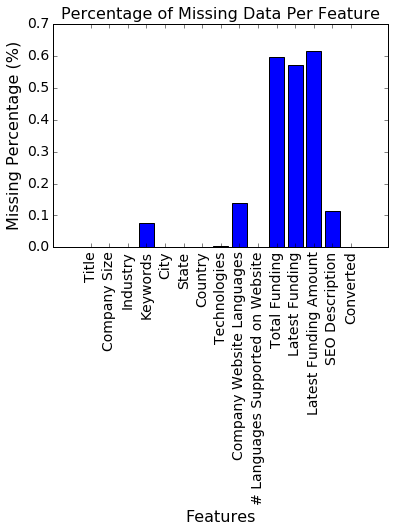

In [10]:
features = df.columns.values
x_pos = np.arange(len(features))
missing_percentages = plot_missing_set_feature_percentages

plt.bar(x_pos, missing_percentages, align='center')
plt.figure(1, figsize=(20, 20))
plt.xticks(x_pos, features, fontsize=14, rotation='vertical')
plt.yticks(fontsize=14)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Missing Percentage (%)', fontsize=16)
plt.title('Percentage of Missing Data Per Feature', fontsize=16) 
plt.show()

Features <b> Keywords </b>, <b> Company Website Languages </b>, all <b> Funding </b> features and 
<b> SEO Description </b> appear to be significantly incomplete; verify numerically.

In [11]:
print features[3], missing_percentages[3]
print features[8], missing_percentages[8]
print features[10], missing_percentages[10]
print features[11], missing_percentages[11]
print features[12], missing_percentages[12]
print features[13], missing_percentages[13]

Keywords 0.07582784151
Company Website Languages 0.13806850541
Total Funding 0.597510373444
Latest Funding 0.57025465788
Latest Funding Amount 0.614677406232
SEO Description 0.114718086405


Analyze <b> Keywords </b> presence in the dataset considering how many converted entries exist relative to NaN entries 

In [12]:
null_idx = pd.isnull(df['Keywords'])
null_index_check = null_idx * range(0,len(df))
print 'Number of NaN entries in Keywords which Converted:\t', \
sum(df['Converted'].loc[null_index_check] == 'TRUE')
print 'Total Converted Entries in the dataset:\t\t\t', sum(df['Converted'] == 'TRUE')
print 'Expressed as a percentage:\t\t\t\t', \
(sum(df['Converted'].loc[null_index_check] == 'TRUE')/sum(df['Converted'] == 'TRUE'))*100, '%'

Number of NaN entries in Keywords which Converted:	19
Total Converted Entries in the dataset:			343
Expressed as a percentage:				5.53935860058 %


Conversions are precious, will keep entries and augment values in <b> Keywords </b> with string '0' 

In [13]:
df['Keywords'].fillna('0',inplace=True)

## Preprocess <b> 'Company Website Languages' </b> feature

In [14]:
np.unique(df['Company Website Languages'])

array([nan, '(800) 721-6135', 'Chinese', 'English', 'English, Chinese',
       'English, Chinese, Russian', 'English, French',
       'English, French, Chinese, Japanese',
       'English, French, Chinese, Japanese, Russian',
       'English, French, Japanese', 'English, French, Japanese, Russian',
       'English, French, Portuguese, Japanese', 'English, French, Spanish',
       'English, French, Spanish, Russian', 'English, German',
       'English, German, Chinese', 'English, German, Chinese, Japanese',
       'English, German, French', 'English, German, French, Chinese',
       'English, German, French, Chinese, Japanese',
       'English, German, French, Italian',
       'English, German, French, Italian, Chinese',
       'English, German, French, Italian, Japanese',
       'English, German, French, Italian, Portuguese, Chinese, Japanese, Russian',
       'English, German, French, Japanese',
       'English, German, French, Portuguese',
       'English, German, French, Russian',
 

Values in <b> Company Website Langauges </b> require significant munging!!   

Appears there is a significant issue with the initial data in that values in one feature are 
crossing into other feature columns.  I will assume, the customer's website is at least in English. Will substitute with <b> English </b> where entries start with:
<ul>
  <li>Google</li>
  <li>(800)</li>
  <li>nan</li>
</ul>

In [15]:
pbar = pyprind.ProgBar(len(df))
df['Company Website Languages'] = df['Company Website Languages'].astype('str')
find_tech_feature_mix = []
for idx in range(0,len(df)):
    if 'Google' in df['Company Website Languages'].loc[idx] or \
       '(800)' in df['Company Website Languages'].loc[idx]  or \
        'nan' in df['Company Website Languages'].loc[idx]:
        find_tech_feature_mix.append(idx)
    pbar.update()
df['Company Website Languages'].loc[find_tech_feature_mix] = 'English'

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:02


While the entries will remain as strings, they require vectorization in order to be used for further analysis

In [16]:
df['Company Website Languages'] = df['Company Website Languages'].map(lambda x: x.lower())
df['Company Website Languages'].map(lambda x: ' '.join([word for word in x.split() if word not in stop]))
df['Company Website Languages'] = df['Company Website Languages'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))
df['Company Website Languages'] = df['Company Website Languages'].map(lambda x: x.split());
np.unique(df['Company Website Languages'])

array([['chinese'], ['english'], ['english', 'chinese'],
       ['english', 'chinese', 'russian'], ['english', 'french'],
       ['english', 'french', 'chinese', 'japanese'],
       ['english', 'french', 'chinese', 'japanese', 'russian'],
       ['english', 'french', 'japanese'],
       ['english', 'french', 'japanese', 'russian'],
       ['english', 'french', 'portuguese', 'japanese'],
       ['english', 'french', 'spanish'],
       ['english', 'french', 'spanish', 'russian'], ['english', 'german'],
       ['english', 'german', 'chinese'],
       ['english', 'german', 'chinese', 'japanese'],
       ['english', 'german', 'french'],
       ['english', 'german', 'french', 'chinese'],
       ['english', 'german', 'french', 'chinese', 'japanese'],
       ['english', 'german', 'french', 'italian'],
       ['english', 'german', 'french', 'italian', 'chinese'],
       ['english', 'german', 'french', 'italian', 'japanese'],
       ['english', 'german', 'french', 'italian', 'portuguese', 'chine

Identify the unique and maximum entry of supported languages

In [17]:
len_cwl = []
for i in range(0,len(df)):
    len_cwl.append(len(df['Company Website Languages'].loc[i]))
keep_max_lan = []
for i in range(0,len(df)):
    if len(df['Company Website Languages'].loc[i]) == max(len_cwl):
        keep_max_lan = df['Company Website Languages'].loc[i]
        print keep_max_lan
        break

['english', 'german', 'spanish', 'french', 'italian', 'portuguese', 'chinese', 'japanese', 'russian']


Build our own dummy references and variable columns for each of the <b> languages </b> listed above, then drop the original column

In [18]:
for langauge in keep_max_lan:
    df[langauge] = ''

pbar = pyprind.ProgBar(len(df))
for elem in range(0,len(df['Company Website Languages'])):
    for langauge in keep_max_lan:
        if langauge in df['Company Website Languages'].loc[elem]:
            df[langauge].loc[elem] = 1
        else:
            df[langauge].loc[elem] = 0
    pbar.update()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:33


In [19]:
df.drop('Company Website Languages', axis=1, inplace=True)

In [20]:
df.head()

,Title,Company Size,Industry,Keywords,City,State,Country,Technologies,# Languages Supported on Website,Total Funding,...,Converted,english,german,spanish,french,italian,portuguese,chinese,japanese,russian
0,Co-founder & CEO,11-50 employees,internet,0,Palo Alto,California,United States,"Google Analytics, Nginx, Mobile Friendly, Clou...",1,NaN,...,FALSE,1,0,0,0,0,0,0,0,0
1,Cofounder,11-50 employees,internet,"food delivery, logistics, operations, crowdsou...",San Francisco,California,United States,"Google Universal Analytics, Mixpanel, Inspectl...",0,2300000,...,FALSE,1,0,0,0,0,0,0,0,0
2,Founder and CEO,1-10 employees,consumer electronics,0,Belgium,Wisconsin,United States,"Google Universal Analytics, Facebook Widget, Y...",1,131040,...,FALSE,1,0,0,0,0,0,0,0,0
3,CEO and Co-Founder,1-10 employees,internet,"campus marketing, textbook search engine, stud...",San Francisco,California,United States,"Facebook Widget, CSS: max-width, CSS: @media, ...",1,40000,...,FALSE,1,0,0,0,0,0,0,0,0
4,Sales Development Representative,11-50 employees,computer software,"crm management, pipeline automation, mobile sa...",Saint Louis,Missouri,United States,"Google Universal Analytics, Google Analytics, ...",1,5550000,...,FALSE,1,0,0,0,0,0,0,0,0


Plot the Frequency of <b> Company Website Languages </b>

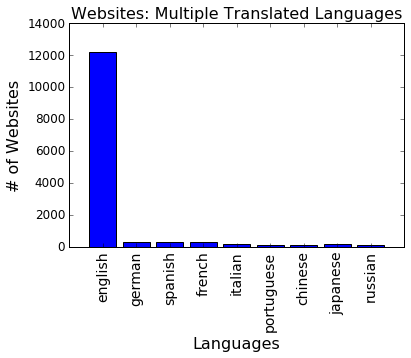

In [21]:
lan_count = []
for lan in keep_max_lan:
    lan_count.append(sum(df[lan]))

x_pos = np.arange(len(keep_max_lan))
count = lan_count

plt.bar(x_pos, lan_count, align='center')
plt.figure(1, figsize=(20, 20))
plt.xticks(x_pos, keep_max_lan, fontsize=14, rotation='vertical')
plt.yticks(fontsize=12)
plt.xlabel('Languages', fontsize=16)
plt.ylabel('# of Websites', fontsize=16)
plt.title('Websites: Multiple Translated Languages', fontsize=16) 
plt.show()

Most of the conversions had English website translation.  Adding <b> English </b> as a dummy feature columns won't be helpful; will remove from dataset.

In [22]:
play = 0
for elem in range(0,len(df)):
    if (df['english'].loc[elem] == 1) and (df['Converted'].loc[elem] == 'TRUE'):
        play = play + 1
print 'Percentage of English website conversions:\t', 100*play/sum(df.Converted == 'TRUE'),'%'

Percentage of English website conversions:	99.7084548105 %


Verify <b> # Languages Supported on Website </b> equals the number of languages accounted for in the dummy variables

In [23]:
sum_lan  = 0
decision = 1
for elem in range(0,len(df['# Languages Supported on Website'])):
    for lan in keep_max_lan:
        sum_lan = sum_lan + df[lan].loc[elem]  
    if df['# Languages Supported on Website'].loc[elem] != sum_lan:
        print "# Languages Supported on Website does not match languages reported, correction needed"
        decision = 0
        break
    sum_lan = 0

# Languages Supported on Website does not match languages reported, correction needed


In [24]:
if(~decision):
    pbar = pyprind.ProgBar(len(df))
    sum_lan = 0        
    for elem in range(0,len(df['# Languages Supported on Website'])):
        for lan in keep_max_lan:
            sum_lan = sum_lan + df[lan].loc[elem]  
        df['# Languages Supported on Website'].loc[elem] = sum_lan
        sum_lan = 0
        pbar.update()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08


In [25]:
df.drop('english', axis=1, inplace=True)

In [26]:
df.head()

,Title,Company Size,Industry,Keywords,City,State,Country,Technologies,# Languages Supported on Website,Total Funding,...,SEO Description,Converted,german,spanish,french,italian,portuguese,chinese,japanese,russian
0,Co-founder & CEO,11-50 employees,internet,0,Palo Alto,California,United States,"Google Analytics, Nginx, Mobile Friendly, Clou...",1,NaN,...,We do magics with videos. Minute is a video op...,FALSE,0,0,0,0,0,0,0,0
1,Cofounder,11-50 employees,internet,"food delivery, logistics, operations, crowdsou...",San Francisco,California,United States,"Google Universal Analytics, Mixpanel, Inspectl...",1,2300000,...,Get all your favorite restaurants and alcohol ...,FALSE,0,0,0,0,0,0,0,0
2,Founder and CEO,1-10 employees,consumer electronics,0,Belgium,Wisconsin,United States,"Google Universal Analytics, Facebook Widget, Y...",1,131040,...,Fleye - Your personal Flying Robot,FALSE,0,0,0,0,0,0,0,0
3,CEO and Co-Founder,1-10 employees,internet,"campus marketing, textbook search engine, stud...",San Francisco,California,United States,"Facebook Widget, CSS: max-width, CSS: @media, ...",1,40000,...,NaN,FALSE,0,0,0,0,0,0,0,0
4,Sales Development Representative,11-50 employees,computer software,"crm management, pipeline automation, mobile sa...",Saint Louis,Missouri,United States,"Google Universal Analytics, Google Analytics, ...",1,5550000,...,Sales Pipeline & Forecast Predictability Solut...,FALSE,0,0,0,0,0,0,0,0


Discover how many of the websites with multiple languages make up conversions in the dataset

In [27]:
count_lsw = 0
for elem in range(0,len(df)):
    if (df['# Languages Supported on Website'].loc[elem] > 1) and (df['Converted'].loc[elem] == 'TRUE'):
        count_lsw = count_lsw + 1
print \
'Conversion % with multiple website translations\t\t{:0.4f}%'.format(count_lsw/sum(df.Converted == 'TRUE')*100)

Conversion % with multiple website translations		3.7901%


The number of conversions found where the user has multiple website language translations are small but still relevant, relative to the percentage of conversions overall.  Later, we'll investigate the language to conversion trends individually.

## Preprocessing <b> 'Title' </b> feature

In [28]:
df['Title'] = df['Title'].map(lambda x: x.lower())
df['Title'] = df['Title'].map(lambda x: ' '.join([word for word in x.split() if word not in stop]))
df['Title'] = df['Title'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))
df['Title'] = df['Title'].map(lambda x: x.split());

title_vector = []
for el1 in range(0,len(df['Title'])):
    for el2 in range(0,len(df['Title'].loc[el1])):
        if  df['Title'].loc[el1][el2] == 'cofounder':
            df['Title'].loc[el1][el2] = 'founder'
            title_vector.append('founder')            
        else:
            title_vector.append(df['Title'].loc[el1][el2])            

print 'Total Titles in Dataset:\t', len(title_vector) 
title_vector = np.unique(title_vector)
print 'Total Unique Titles in Dataset:\t', len(title_vector)
print 'Removing "co" from title_vector since we can treat co-founders and founders synonymously:'
title_vector = title_vector[title_vector != 'co']
print 'Total Unique Titles in Dataset:\t', len(title_vector)

Total Titles in Dataset:	33761
Total Unique Titles in Dataset:	890
Removing "co" from title_vector since we can treat co-founders and founders synonymously:
Total Unique Titles in Dataset:	889


Understand some properties of <b> Converted </b> via the feature <b> Title </b>

In [29]:
converted_title_freq_vector = []
for el1 in range(0,len(df)):
    if (df['Converted'].loc[el1] == 'TRUE'):
        for el2 in range(0,len(df['Title'].loc[el1])):
            if df['Title'].loc[el1][el2] in title_vector:
                converted_title_freq_vector.append(df['Title'].loc[el1][el2])

dict_converted_title_freq_vector = defaultdict( int )
for w in converted_title_freq_vector:
    dict_converted_title_freq_vector[w] += 1    
converted_titles = dict(Counter(dict_converted_title_freq_vector).most_common(20))
print converted_titles

{'development': 26, 'vp': 21, 'business': 14, 'founder': 181, 'vice': 11, 'ceo': 115, 'marketing': 43, 'sales': 77, 'operations': 8, 'director': 46, 'chief': 15, 'manager': 27, 'growth': 11, 'officer': 14, 'cmo': 12, 'president': 17, 'senior': 9, 'cto': 15, 'coo': 5, 'representative': 10}


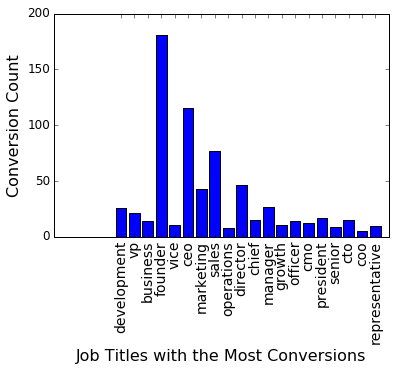

In [30]:
x_pos = range(0,len(converted_titles))
plt.bar(x_pos, converted_titles.values(), align='center')
plt.xticks(range(len(converted_titles)), converted_titles.keys(), rotation='vertical', fontsize=14)
plt.figure(1, figsize=(20, 20))
plt.yticks(fontsize=12)
plt.xlabel('Job Titles with the Most Conversions', fontsize=16)
plt.ylabel('Conversion Count', fontsize=16)
plt.show()

# Actionable Response

Going forward, emphasis should be placed on keeping consistent contact with <b> founders </b>, <b> ceos </b> and
<b> sales </b> officers since they convert the most.

Understand some properties of <b> Non-Converted </b> via the feature <b> Title </b>

In [31]:
non_converted_title_freq_vector = []
for el1 in range(0,len(df)):
    if (df['Converted'].loc[el1] == 'FALSE'):
        for el2 in range(0,len(df['Title'].loc[el1])):
            if df['Title'].loc[el1][el2] in title_vector:
                non_converted_title_freq_vector.append(df['Title'].loc[el1][el2])

dict_non_converted_title_freq_vector = defaultdict( int )
for w in non_converted_title_freq_vector:
    dict_non_converted_title_freq_vector[w] += 1    
non_converted_titles = dict(Counter(dict_non_converted_title_freq_vector).most_common(20))
print non_converted_titles

{'development': 761, 'vp': 1008, 'product': 281, 'business': 424, 'founder': 5135, 'vice': 891, 'ceo': 3485, 'marketing': 2121, 'executive': 317, 'sales': 3377, 'director': 1713, 'chief': 433, 'manager': 1401, 'officer': 365, 'operations': 284, 'cmo': 239, 'president': 1230, 'senior': 289, 'cto': 373, 'representative': 336}


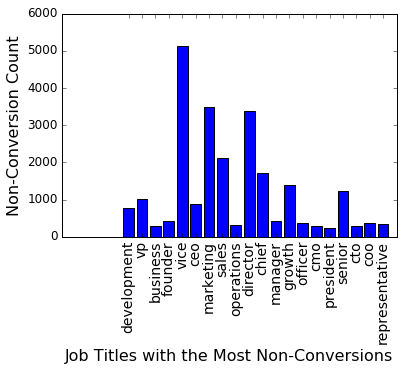

In [32]:
x_pos = range(0,len(non_converted_titles))
plt.bar(x_pos, non_converted_titles.values(), align='center')
plt.xticks(range(len(non_converted_titles)), converted_titles.keys(), rotation='vertical', fontsize=14)
plt.figure(1, figsize=(20, 20))
plt.yticks(fontsize=12)
plt.xlabel('Job Titles with the Most Non-Conversions', fontsize=16)
plt.ylabel('Non-Conversion Count', fontsize=16)
plt.show()

# Actionable Response

Going forward, de-emphasis on middle management contact since <b> vice (or vice presidents) </b>, <b> marketing personnel </b> and <b> directors </b> show the most non-converting trend 
(i.e., show the most interest but convert the least).

Merge the <b> Titles </b> from both the Conversions and Non-Conversions Used in Dataset.  We'll treat these
as categorical variables and transform them to dummy variables in our model.

In [33]:
nct_set = []
ct_set = []

for key, value in non_converted_titles.iteritems() :
     nct_set.append(key)
for key, value in converted_titles.iteritems() :
     ct_set.append(key)
        
nct_set.sort() 
ct_set.sort()
top_titles = np.unique(nct_set + ct_set)
print top_titles

['business' 'ceo' 'chief' 'cmo' 'coo' 'cto' 'development' 'director'
 'executive' 'founder' 'growth' 'manager' 'marketing' 'officer'
 'operations' 'president' 'product' 'representative' 'sales' 'senior'
 'vice' 'vp']


Build our own dummy references and variable columns for each of the <b> titles </b> listed above, then drop the original column

In [34]:
for title in top_titles:
    df[title] = ''

In [35]:
pbar = pyprind.ProgBar(len(df))
for el1 in range(0,len(df['Title'])):
    for el2 in range(0,len(df['Title'].loc[el1])):
        for title in top_titles:
            if title == df['Title'].loc[el1][el2]:
                df[title].loc[el1] = 1
    pbar.update()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:35


In [36]:
for title in top_titles:
    df[title].replace('', 0, inplace=True)                

In [37]:
df.drop('Title', axis= 1, inplace=True)

## Preprocessing <b> 'Industry' </b> feature

The <b> Industry </b> feature is organized in the same vein as the <b> Title </b> feature.  Perform similar operations to translate it to operationable data.

In [38]:
df['Industry'] = df['Industry'].map(lambda x: x.lower())
df['Industry'] = df['Industry'].map(lambda x: ' '.join([word for word in x.split() if word not in stop]))
df['Industry'] = df['Industry'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))
df['Industry'] = df['Industry'].map(lambda x: x.split());

There are name conflicts <i> marketing </i> in <b> Titles </b> and <b> Industry </b> in constructing dummy variables. Changing <i> marketing </i> in <b> Industry </b> to <i> marketing </i>

In [39]:
for el1 in range(0,len(df['Industry'])):
    for el2 in range(0,len(df['Industry'].loc[el1])):
        if df['Industry'].loc[el1][el2] == 'marketing':
            df['Industry'].loc[el1][el2] = 'publicizing'

industry_vector = []
for el1 in range(0,len(df['Industry'])):
    for el2 in range(0,len(df['Industry'].loc[el1])):
            industry_vector.append(df['Industry'].loc[el1][el2])            

In [40]:
print 'Total Industries in Dataset:\t\t', len(industry_vector) 
industry_vector = np.unique(industry_vector)
print 'Total Unique Industries in Dataset:\t', len(industry_vector)

Total Industries in Dataset:		24139
Total Unique Industries in Dataset:	200


Understand some properties of <b> Converted </b> via the feature <b> Industry </b>

In [41]:
converted_industry_freq_vector = []
for el1 in range(0,len(df)):
    if (df['Converted'].loc[el1] == 'TRUE'):
        for el2 in range(0,len(df['Industry'].loc[el1])):
            if df['Industry'].loc[el1][el2] in industry_vector:
                converted_industry_freq_vector.append(df['Industry'].loc[el1][el2])

dict_converted_industry_freq_vector = defaultdict( int )
for w in converted_industry_freq_vector:
    dict_converted_industry_freq_vector[w] += 1    
converted_industry = dict(Counter(dict_converted_industry_freq_vector).most_common(10))
print converted_industry

{'information': 53, 'advertising': 33, 'financial': 8, 'computer': 111, 'health': 8, 'publicizing': 33, 'internet': 72, 'services': 64, 'technology': 52, 'software': 106}


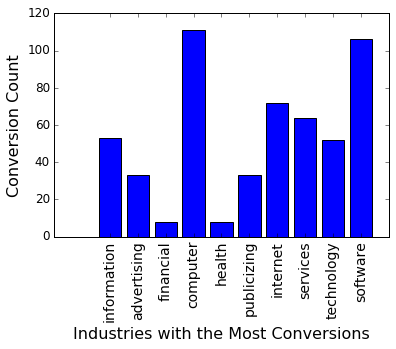

In [42]:
x_pos = range(0,len(converted_industry))
plt.bar(x_pos, converted_industry.values(), align='center')
plt.xticks(range(len(converted_industry)), converted_industry.keys(), rotation='vertical', fontsize=14)
plt.figure(1, figsize=(20, 20))
plt.yticks(fontsize=12)
plt.xlabel('Industries with the Most Conversions', fontsize=16)
plt.ylabel('Conversion Count', fontsize=16)
plt.show()

# Actionable Response

Going forward, emphasize <b> software </b> related companies which provide possible SaaS (given the results from <b> services </b> and <b> advertising </b> related companies. <b> Computer </b>, <b> internet </b> and <b> information </b> are fairly terms associated with many of the companies and therefore should not be considered as explicit industries.  

Understand some properties of <b> Non-Converted </b> via the feature <b> Industry </b>

In [43]:
non_converted_industry_freq_vector = []
for el1 in range(0,len(df)):
    if (df['Converted'].loc[el1] == 'FALSE'):
        for el2 in range(0,len(df['Industry'].loc[el1])):
            if df['Industry'].loc[el1][el2] in industry_vector:
                non_converted_industry_freq_vector.append(df['Industry'].loc[el1][el2])

dict_non_converted_industry_freq_vector = defaultdict( int )
for w in non_converted_industry_freq_vector:
    dict_non_converted_industry_freq_vector[w] += 1    
non_converted_industry = dict(Counter(dict_non_converted_industry_freq_vector).most_common(10))
print non_converted_industry

{'information': 1913, 'advertising': 915, 'financial': 173, 'computer': 4600, 'health': 182, 'publicizing': 915, 'internet': 2169, 'services': 2188, 'technology': 1865, 'software': 4411}


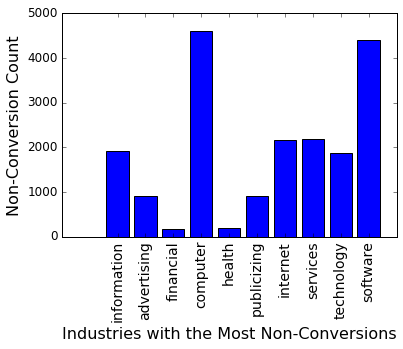

In [44]:
x_pos = range(0,len(non_converted_industry))
plt.bar(x_pos, non_converted_industry.values(), align='center')
plt.xticks(range(len(non_converted_industry)), non_converted_industry.keys(), rotation='vertical', fontsize=14)
plt.figure(1, figsize=(20, 20))
plt.yticks(fontsize=12)
plt.xlabel('Industries with the Most Non-Conversions', fontsize=16)
plt.ylabel('Non-Conversion Count', fontsize=16)
plt.show()

# Actionable Response

The results are extremly similar to the <b> Converted </b> analysis in terms of <b> Industry </b>.  For as many conversions in the industries provided in the <b> Converted </b> analysis ...   Expect that there will be significant non-conversions as well in the same industries.

Merge the <b> Industry </b> from both the Conversions and Non-Conversions Used in Dataset.  We'll treat these
as categorical variables and transform them to dummy variables in our model.

In [45]:
nct_set = []
ct_set = []

for key, value in non_converted_industry.iteritems() :
     nct_set.append(key)
for key, value in converted_industry.iteritems() :
     ct_set.append(key)
        
nct_set.sort() 
ct_set.sort()
top_industries = np.unique(nct_set + ct_set)
print '\nTop Industries:\n'
print top_industries


Top Industries:

['advertising' 'computer' 'financial' 'health' 'information' 'internet'
 'publicizing' 'services' 'software' 'technology']


Build our own dummy references and variable columns for each of the <b> Industry </b> listed above, then drop the original column

In [46]:
for industry in top_industries:
    df[industry] = ''

for industry in top_industries:
    df[industry].replace('', 0, inplace=True)

pbar = pyprind.ProgBar(len(df))
for idx in range(0,len(df)):
    alpha = [i for i in df['Industry'].loc[idx] if i in top_industries]
    alpha_idx = np.zeros(len(top_industries))
    for subidx in range(0,len(alpha)):
        alpha_idx[top_industries.tolist().index(alpha[subidx])] = 1
    df.loc[idx, top_industries] = alpha_idx
    pbar.update()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:38


In [47]:
df.drop('Industry', axis=1, inplace=True)

In [48]:
df.head()

,Company Size,Keywords,City,State,Country,Technologies,# Languages Supported on Website,Total Funding,Latest Funding,Latest Funding Amount,...,advertising,computer,financial,health,information,internet,publicizing,services,software,technology
0,11-50 employees,0,Palo Alto,California,United States,"Google Analytics, Nginx, Mobile Friendly, Clou...",1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,11-50 employees,"food delivery, logistics, operations, crowdsou...",San Francisco,California,United States,"Google Universal Analytics, Mixpanel, Inspectl...",1,2300000,Seed,2300000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1-10 employees,0,Belgium,Wisconsin,United States,"Google Universal Analytics, Facebook Widget, Y...",1,131040,Seed,131040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1-10 employees,"campus marketing, textbook search engine, stud...",San Francisco,California,United States,"Facebook Widget, CSS: max-width, CSS: @media, ...",1,40000,Venture,40000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,11-50 employees,"crm management, pipeline automation, mobile sa...",Saint Louis,Missouri,United States,"Google Universal Analytics, Google Analytics, ...",1,5550000,Seed,1600000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Preprocessing <b> 'Keywords' </b> feature

In [49]:
df['Keywords'] = df['Keywords'].map(lambda x: x.lower())
df['Keywords'] = df['Keywords'].map(lambda x: ' '.join([word for word in x.split() if word not in stop]))
df['Keywords'] = df['Keywords'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))
df['Keywords'] = df['Keywords'].map(lambda x: x.split());

Add '_k' to the end of the keywords so they do not name clash with other categorical variables in Industry and Title (and any other) features

In [50]:
keyword_vector = []

for el1 in range(0,len(df['Keywords'])):
    for el2 in range(0,len(df['Keywords'].loc[el1])):
        df['Keywords'].loc[el1][el2] =  df['Keywords'].loc[el1][el2] + '_k'

for el1 in range(0,len(df['Keywords'])):
    for el2 in range(0,len(df['Keywords'].loc[el1])):
        keyword_vector.append(df['Keywords'].loc[el1][el2])            

print 'Total Keywords in Dataset:\t\t', len(keyword_vector) 
keyword_vector = np.unique(keyword_vector)
print 'Total Unique Keywords in Dataset:\t', len(keyword_vector)

Total Keywords in Dataset:		168689
Total Unique Keywords in Dataset:	8775


Understand some properties of <b> Converted </b> via the feature <b> Keyword </b>

In [51]:
converted_keyword_freq_vector = []
for el1 in range(0,len(df)):
    if (df['Converted'].loc[el1] == 'TRUE'):
        for el2 in range(0,len(df['Keywords'].loc[el1])):
            if df['Keywords'].loc[el1][el2] in keyword_vector:
                converted_keyword_freq_vector.append(df['Keywords'].loc[el1][el2])

dict_converted_keyword_freq_vector = defaultdict( int )
for w in converted_keyword_freq_vector:
    dict_converted_keyword_freq_vector[w] += 1    
converted_keyword = dict(Counter(dict_converted_keyword_freq_vector).most_common(20))
print converted_keyword

{'recruiting_k': 42, 'development_k': 42, 'analytics_k': 112, 'cloud_k': 44, 'social_k': 79, 'data_k': 105, 'services_k': 45, 'online_k': 41, 'management_k': 117, 'content_k': 46, 'big_k': 44, 'software_k': 114, 'technology_k': 41, 'sales_k': 39, 'saas_k': 92, 'media_k': 60, 'mobile_k': 98, 'marketing_k': 161, 'business_k': 65, 'enterprise_k': 61}


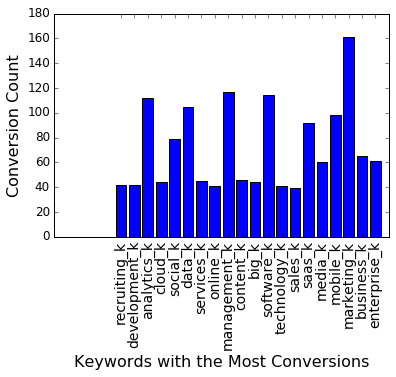

In [52]:
x_pos = range(0,len(converted_keyword))
plt.bar(x_pos, converted_keyword.values(), align='center')
plt.xticks(range(len(converted_keyword)), converted_keyword.keys(), rotation='vertical', fontsize=14)
plt.figure(1, figsize=(20, 20))
plt.yticks(fontsize=12)
plt.xlabel('Keywords with the Most Conversions', fontsize=16)
plt.ylabel('Conversion Count', fontsize=16)
plt.show()

Understand some properties of <b> Non-Converted </b> via the feature <b> Keyword </b>

In [53]:
non_converted_keyword_freq_vector = []

pbar = pyprind.ProgBar(len(df))
for el1 in range(0,len(df)):
    if (df['Converted'].loc[el1] == 'FALSE'):
        for el2 in range(0,len(df['Keywords'].loc[el1])):
            if df['Keywords'].loc[el1][el2] in keyword_vector:
                non_converted_keyword_freq_vector.append(df['Keywords'].loc[el1][el2])
    pbar.update()
    
dict_non_converted_keyword_freq_vector = defaultdict( int )
for w in non_converted_keyword_freq_vector:
    dict_non_converted_keyword_freq_vector[w] += 1    
non_converted_keyword = dict(Counter(dict_non_converted_keyword_freq_vector).most_common(20))
print non_converted_keyword

0%                          100%
[##############################] | ETA: 00:00:00

{'web_k': 1354, 'sales_k': 1205, 'analytics_k': 2714, 'cloud_k': 1957, 'social_k': 2530, 'data_k': 3783, 'development_k': 1804, 'online_k': 1185, 'management_k': 3833, 'services_k': 1615, 'big_k': 1514, 'software_k': 4571, 'technology_k': 1470, 'advertising_k': 1488, 'saas_k': 2113, 'media_k': 2085, 'mobile_k': 3468, 'marketing_k': 4253, 'business_k': 1408, 'enterprise_k': 2461}



Total time elapsed: 00:01:00


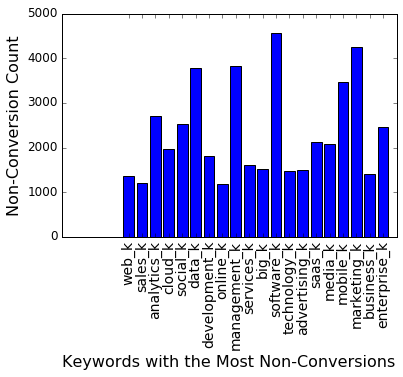

In [54]:
x_pos = range(0,len(non_converted_keyword))
plt.bar(x_pos, non_converted_keyword.values(), align='center')
plt.xticks(range(len(non_converted_keyword)), non_converted_keyword.keys(), rotation='vertical', fontsize=14)
plt.figure(1, figsize=(20, 20))
plt.yticks(fontsize=12)
plt.xlabel('Keywords with the Most Non-Conversions', fontsize=16)
plt.ylabel('Non-Conversion Count', fontsize=16)
plt.show()

# Actionable Response

The results are extremly similar to the <b> Industry </b> analysis in terms of <b> Converted </b> and <b> Non-Converted </b>.  For as many conversions on the <b> Keywords </b> provided in the charts ...   Expect that there will be significant non-conversions as well among the same <b> Keywords </b>.

Merge the <b> Keywords </b> from both the Conversions and Non-Conversions Used in Dataset.  We'll treat these
as categorical variables and transform them to dummy variables in our model.

In [55]:
nct_set = []
ct_set = []

for key, value in non_converted_keyword.iteritems() :
     nct_set.append(key)
for key, value in converted_keyword.iteritems() :
     ct_set.append(key)
        
nct_set.sort() 
ct_set.sort()
top_keyword = np.unique(nct_set + ct_set)
print '\nTop Keywords:\n'
print top_keyword


Top Keywords:

['advertising_k' 'analytics_k' 'big_k' 'business_k' 'cloud_k' 'content_k'
 'data_k' 'development_k' 'enterprise_k' 'management_k' 'marketing_k'
 'media_k' 'mobile_k' 'online_k' 'recruiting_k' 'saas_k' 'sales_k'
 'services_k' 'social_k' 'software_k' 'technology_k' 'web_k']


In [56]:
for keyword in top_keyword:
    df[keyword] = ''

pbar = pyprind.ProgBar(len(df))
for idx in range(0,len(df)):
    alpha = [i for i in df['Keywords'].loc[idx] if i in top_keyword]
    alpha_idx = np.zeros(len(top_keyword))
    for subidx in range(0,len(alpha)):
        alpha_idx[top_keyword.tolist().index(alpha[subidx])] = 1
    df.loc[idx, top_keyword] = alpha_idx
    pbar.update()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:02:40


In [57]:
df.drop('Keywords', axis=1, inplace=True)

In [58]:
df.head()

,Company Size,City,State,Country,Technologies,# Languages Supported on Website,Total Funding,Latest Funding,Latest Funding Amount,SEO Description,...,mobile_k,online_k,recruiting_k,saas_k,sales_k,services_k,social_k,software_k,technology_k,web_k
0,11-50 employees,Palo Alto,California,United States,"Google Analytics, Nginx, Mobile Friendly, Clou...",1,NaN,NaN,NaN,We do magics with videos. Minute is a video op...,...,0,0,0,0,0,0,0,0,0,0
1,11-50 employees,San Francisco,California,United States,"Google Universal Analytics, Mixpanel, Inspectl...",1,2300000,Seed,2300000,Get all your favorite restaurants and alcohol ...,...,0,1,0,0,0,0,0,0,0,0
2,1-10 employees,Belgium,Wisconsin,United States,"Google Universal Analytics, Facebook Widget, Y...",1,131040,Seed,131040,Fleye - Your personal Flying Robot,...,0,0,0,0,0,0,0,0,0,0
3,1-10 employees,San Francisco,California,United States,"Facebook Widget, CSS: max-width, CSS: @media, ...",1,40000,Venture,40000,NaN,...,0,0,0,0,0,0,0,0,0,0
4,11-50 employees,Saint Louis,Missouri,United States,"Google Universal Analytics, Google Analytics, ...",1,5550000,Seed,1600000,Sales Pipeline & Forecast Predictability Solut...,...,1,0,0,0,1,0,0,0,0,0


## Preprocessing <b> 'Technologies' </b> feature

In [59]:
df['Technologies'].fillna('none', inplace=True)
df['Technologies'] = df['Technologies'].map(lambda x: x.lower())
df['Technologies'] = df['Technologies'].map(lambda x: ' '.join([word for word 
                                                                            in x.split() if word not in stop]))
df['Technologies'] = df['Technologies'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))
df['Technologies'] = df['Technologies'].map(lambda x: x.split());

Add '_t' to the end of the <b> technologies </b> so they do not name clash with other categorical variables

In [60]:
technologies_vector = []

for el1 in range(0,len(df['Technologies'])):
    for el2 in range(0,len(df['Technologies'].loc[el1])):
        df['Technologies'].loc[el1][el2] =  df['Technologies'].loc[el1][el2] + '_t'

for el1 in range(0,len(df['Technologies'])):
    for el2 in range(0,len(df['Technologies'].loc[el1])):
        technologies_vector.append(df['Technologies'].loc[el1][el2])            

print 'Total Technologies in Dataset:\t\t', len(technologies_vector) 
technologies_vector = np.unique(technologies_vector)
print 'Total Unique Technologies in Dataset:\t', len(technologies_vector)

Total Technologies in Dataset:		334540
Total Unique Technologies in Dataset:	944


Understand some properties of <b> Converted </b> via the feature <b> Technologies </b>

In [61]:
converted_technologies_freq_vector = []
for el1 in range(0,len(df)):
    if (df['Converted'].loc[el1] == 'TRUE'):
        for el2 in range(0,len(df['Technologies'].loc[el1])):
            if df['Technologies'].loc[el1][el2] in technologies_vector:
                converted_technologies_freq_vector.append(df['Technologies'].loc[el1][el2])

dict_converted_technologies_freq_vector = defaultdict( int )
for w in converted_technologies_freq_vector:
    dict_converted_technologies_freq_vector[w] += 1    
converted_technologies = dict(Counter(dict_converted_technologies_freq_vector).most_common(10))
print converted_technologies

{'gmail_t': 504, 'mobile_t': 315, 'apps_t': 309, 'css_t': 377, 'google_t': 1181, 'font_t': 309, 'spf_t': 214, 'analytics_t': 322, 'universal_t': 214, 'friendly_t': 315}


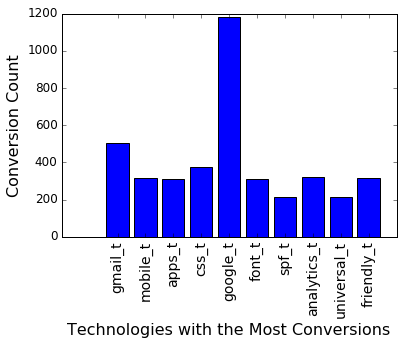

In [62]:
x_pos = range(0,len(converted_technologies))
plt.bar(x_pos, converted_technologies.values(), align='center')
plt.xticks(range(len(converted_technologies)), converted_technologies.keys(), rotation='vertical', fontsize=14)
plt.figure(1, figsize=(20, 20))
plt.yticks(fontsize=12)
plt.xlabel('Technologies with the Most Conversions', fontsize=16)
plt.ylabel('Conversion Count', fontsize=16)
plt.show()

Understand some properties of <b> Non-Converted </b> via the feature <b> Technologies </b>

In [63]:
pbar = pyprind.ProgBar(len(df))
non_converted_technologies_freq_vector = []
for el1 in range(0,len(df)):
    if (df['Converted'].loc[el1] == 'FALSE'):
        for el2 in range(0,len(df['Technologies'].loc[el1])):
            if df['Technologies'].loc[el1][el2] in technologies_vector:
                non_converted_technologies_freq_vector.append(df['Technologies'].loc[el1][el2])
    pbar.update()

dict_non_converted_technologies_freq_vector = defaultdict( int )
for w in non_converted_technologies_freq_vector:
    dict_non_converted_technologies_freq_vector[w] += 1    
non_converted_technologies = dict(Counter(dict_non_converted_technologies_freq_vector).most_common(10))
print non_converted_technologies

0%                          100%
[##############################] | ETA: 00:00:00

{'gmail_t': 13683, 'mobile_t': 9993, 'apps_t': 8633, 'css_t': 12556, 'google_t': 36296, 'font_t': 10001, 'php_t': 7052, 'analytics_t': 10390, 'width_t': 6538, 'friendly_t': 9993}



Total time elapsed: 00:00:37


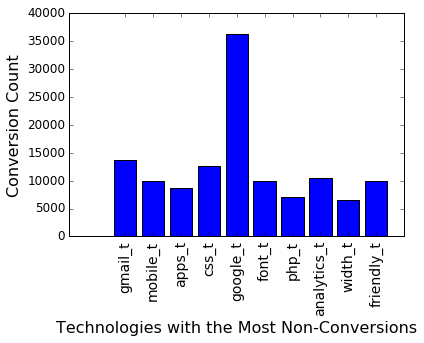

In [64]:
x_pos = range(0,len(non_converted_technologies))
plt.bar(x_pos, non_converted_technologies.values(), align='center')
plt.xticks(range(len(non_converted_technologies)), non_converted_technologies.keys(), \
           rotation='vertical', fontsize=14)
plt.figure(1, figsize=(20, 20))
plt.yticks(fontsize=12)
plt.xlabel('Technologies with the Most Non-Conversions', fontsize=16)
plt.ylabel('Conversion Count', fontsize=16)
plt.show()

# Actionable Response

Looks like everyone in our sample is a <b> Google </b> product user. It appears that the type of technologies used will support the separation between <b> Converted </b> and <b> Non-Converted </b> users.  The frequencies between <b> Converted </b> and <b> Non-Converted </b> are the same in both charts.  Will keep in the data set for further analysis.

In [65]:
nct_set = []
ct_set = []

for key, value in non_converted_technologies.iteritems() :
     nct_set.append(key)
for key, value in converted_technologies.iteritems() :
     ct_set.append(key)
        
nct_set.sort() 
ct_set.sort()
top_technologies = np.unique(nct_set + ct_set)
print '\nTop Technologies:\n'
print top_technologies


Top Technologies:

['analytics_t' 'apps_t' 'css_t' 'font_t' 'friendly_t' 'gmail_t' 'google_t'
 'mobile_t' 'php_t' 'spf_t' 'universal_t' 'width_t']


In [66]:
for technology in top_technologies:
    df[technology] = ''

pbar = pyprind.ProgBar(len(df))
for idx in range(0,len(df)):
    alpha = [i for i in df['Technologies'].loc[idx] if i in top_technologies]
    alpha_idx = np.zeros(len(top_technologies))
    for subidx in range(0,len(alpha)):
        alpha_idx[top_technologies.tolist().index(alpha[subidx])] = 1
    df.loc[idx, top_technologies] = alpha_idx
    pbar.update()

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:49


In [67]:
df.drop('Technologies', axis=1, inplace=True)

In [68]:
df.head()

,Company Size,City,State,Country,# Languages Supported on Website,Total Funding,Latest Funding,Latest Funding Amount,SEO Description,Converted,...,css_t,font_t,friendly_t,gmail_t,google_t,mobile_t,php_t,spf_t,universal_t,width_t
0,11-50 employees,Palo Alto,California,United States,1,NaN,NaN,NaN,We do magics with videos. Minute is a video op...,FALSE,...,0,0,1,1,1,1,0,0,0,0
1,11-50 employees,San Francisco,California,United States,1,2300000,Seed,2300000,Get all your favorite restaurants and alcohol ...,FALSE,...,0,0,1,1,1,1,0,1,1,0
2,1-10 employees,Belgium,Wisconsin,United States,1,131040,Seed,131040,Fleye - Your personal Flying Robot,FALSE,...,0,0,1,1,1,1,1,0,1,0
3,1-10 employees,San Francisco,California,United States,1,40000,Venture,40000,NaN,FALSE,...,1,0,1,0,0,1,0,0,0,1
4,11-50 employees,Saint Louis,Missouri,United States,1,5550000,Seed,1600000,Sales Pipeline & Forecast Predictability Solut...,FALSE,...,1,1,1,1,1,1,1,1,1,1


## Investigate 'Funding' features and missing values relative to Converts and Non-Converts

In [69]:
counter = 0
for elem in range(0,len(df)):
    if (~pd.isnull(df['Total Funding'].loc[elem])) and (df['Converted'].loc[elem] == 'TRUE'):
        counter = counter + 1
print \
'(%) conversions that reported their funding:\t\t\t{:0.4f}%'.format(counter/sum(df.Converted == 'TRUE')*100)

counter = 0
for elem in range(0,len(df)):
    if (pd.isnull(df['Total Funding'].loc[elem])) and (df['Converted'].loc[elem] == 'TRUE'):
        counter = counter + 1
print \
'(%) conversions that did not report their funding:\t\t{:0.4f}%'.format(counter/sum(df.Converted == 'TRUE')*100)

(%) conversions that reported their funding:			100.0000%
(%) conversions that did not report their funding:		51.0204%


In [70]:
counter = 0
for elem in range(0,len(df)):
    if (~pd.isnull(df['Latest Funding'].loc[elem])) and (df['Converted'].loc[elem] == 'TRUE'):
        counter = counter + 1
print \
'(%) conversions that reported their funding stage:\t\t\t{:0.4f}%'.format(counter/sum(df.Converted == 'TRUE')*100)

counter = 0
for elem in range(0,len(df)):
    if (pd.isnull(df['Latest Funding'].loc[elem])) and (df['Converted'].loc[elem] == 'TRUE'):
        counter = counter + 1
print \
'(%) conversions that did not report their funding stage:\t\t{:0.4f}%'.format(counter/sum(df.Converted == 'TRUE')*100)


(%) conversions that reported their funding stage:			100.0000%
(%) conversions that did not report their funding stage:		47.8134%


In [71]:
counter = 0
for elem in range(0,len(df)):
    if (~pd.isnull(df['Latest Funding Amount'].loc[elem])) and (df['Converted'].loc[elem] == 'TRUE'):
        counter = counter + 1
print \
'(%) conversions that did report their lates funding amount:\t\t{:0.4f}%'.format(counter/sum(df.Converted == 'TRUE')*100)

counter = 0
for elem in range(0,len(df)):
    if (pd.isnull(df['Latest Funding Amount'].loc[elem])) and (df['Converted'].loc[elem] == 'TRUE'):
        counter = counter + 1
print \
'(%) conversions that did not report their lates funding amount:\t\t{:0.4f}%'.format(counter/sum(df.Converted == 'TRUE')*100)


(%) conversions that did report their lates funding amount:		100.0000%
(%) conversions that did not report their lates funding amount:		53.3528%


Approximately half of the conversions do not report:

<ul>
  <li>Total Funding </li>
  <li>Total Funding </li>
  <li>Latest Funding Amount </li>
</ul>

Therefore, will fill with zeros and keep for further analysis

In [72]:
df['Total Funding'].fillna(0,inplace=True)
df['Latest Funding'].fillna(0,inplace=True)
df['Latest Funding Amount'].fillna(0,inplace=True)

In [73]:
df.head()

,Company Size,City,State,Country,# Languages Supported on Website,Total Funding,Latest Funding,Latest Funding Amount,SEO Description,Converted,...,css_t,font_t,friendly_t,gmail_t,google_t,mobile_t,php_t,spf_t,universal_t,width_t
0,11-50 employees,Palo Alto,California,United States,1,0,0,0,We do magics with videos. Minute is a video op...,FALSE,...,0,0,1,1,1,1,0,0,0,0
1,11-50 employees,San Francisco,California,United States,1,2300000,Seed,2300000,Get all your favorite restaurants and alcohol ...,FALSE,...,0,0,1,1,1,1,0,1,1,0
2,1-10 employees,Belgium,Wisconsin,United States,1,131040,Seed,131040,Fleye - Your personal Flying Robot,FALSE,...,0,0,1,1,1,1,1,0,1,0
3,1-10 employees,San Francisco,California,United States,1,40000,Venture,40000,NaN,FALSE,...,1,0,1,0,0,1,0,0,0,1
4,11-50 employees,Saint Louis,Missouri,United States,1,5550000,Seed,1600000,Sales Pipeline & Forecast Predictability Solut...,FALSE,...,1,1,1,1,1,1,1,1,1,1


## Preprocessing 'Company Size'

Design mapping function from string representation to ordinal values

In [74]:
def company_size_encoding(df_elem):
    if df_elem == '1-10 employees':
        return 0
    elif df_elem == '11-50 employees':
        return 1
    elif df_elem == '51-200 employees':
        return 2
    elif df_elem == '201-500 employees':
        return 3
    elif df_elem == '501-1000 employees':
        return 4
    elif df_elem == '1001-5000 employees':
        return 5
    elif df_elem == '5001-10,000 employees':
        return 6
    else:
        return 7

In [75]:
df['Company Size'] = df['Company Size'].map(lambda x: company_size_encoding(x))

In [76]:
df.head()

,Company Size,City,State,Country,# Languages Supported on Website,Total Funding,Latest Funding,Latest Funding Amount,SEO Description,Converted,...,css_t,font_t,friendly_t,gmail_t,google_t,mobile_t,php_t,spf_t,universal_t,width_t
0,1,Palo Alto,California,United States,1,0,0,0,We do magics with videos. Minute is a video op...,FALSE,...,0,0,1,1,1,1,0,0,0,0
1,1,San Francisco,California,United States,1,2300000,Seed,2300000,Get all your favorite restaurants and alcohol ...,FALSE,...,0,0,1,1,1,1,0,1,1,0
2,0,Belgium,Wisconsin,United States,1,131040,Seed,131040,Fleye - Your personal Flying Robot,FALSE,...,0,0,1,1,1,1,1,0,1,0
3,0,San Francisco,California,United States,1,40000,Venture,40000,NaN,FALSE,...,1,0,1,0,0,1,0,0,0,1
4,1,Saint Louis,Missouri,United States,1,5550000,Seed,1600000,Sales Pipeline & Forecast Predictability Solut...,FALSE,...,1,1,1,1,1,1,1,1,1,1


## Preprocess 'Latest Funding'

In [77]:
np.unique(df['Latest Funding'])

array([0, '1', 'Angel', 'Other', 'Private Equity', 'Seed', 'Series A',
       'Series B', 'Series C', 'Series D', 'Series E', 'Series F',
       'Series G', 'Venture'], dtype=object)

Design mapping function from string representation to ordinal values

In [78]:
df['Latest Funding'].fillna(0,inplace=True)
latest_funding_mappings = {
                             0: 0,
                            'Other': 0, 
                            'Seed': 1,
                            'Angel': 2,
                            'Series A': 3,
                            'Series B': 4,
                            'Series C': 5,
                            'Series D': 6,
                            'Series E': 7,
                            'Series F': 8,
                            'Series G': 9,
                            'Venture': 10,
                            'Private Equity': 11
                          }

In [79]:
df['Latest Funding'] = df['Latest Funding'].map(latest_funding_mappings)

## Preprocess 'Totaling Funding'

Remove anomaly from the data set from values in one feature column merging into another. 

In [80]:
for elem in range(0, len(df['Total Funding'])):
    if df['Total Funding'].loc[elem] == 'English':
        df['Total Funding'].loc[elem] = 0
df['Total Funding'] = df['Total Funding'].astype('float')

In [81]:
df['Total Funding'].fillna(0,inplace=True)

Scale the funding amounts relative to a max_min scale.

In [82]:
def min_max_scale_encoder(max_val, min_val, element):
    return float((element - min_val)/(max_val - min_val))

df['Total Funding'] = df['Total Funding'].map(lambda x: min_max_scale_encoder(
                                                                max(df['Total Funding']),
                                                                min(df['Total Funding']), x))

In [83]:
df['Total Funding'] = df['Total Funding'].map(lambda x: float(x))

In [84]:
df.head()

,Company Size,City,State,Country,# Languages Supported on Website,Total Funding,Latest Funding,Latest Funding Amount,SEO Description,Converted,...,css_t,font_t,friendly_t,gmail_t,google_t,mobile_t,php_t,spf_t,universal_t,width_t
0,1,Palo Alto,California,United States,1,0.000000,0.0,0,We do magics with videos. Minute is a video op...,FALSE,...,0,0,1,1,1,1,0,0,0,0
1,1,San Francisco,California,United States,1,0.000732,1.0,2300000,Get all your favorite restaurants and alcohol ...,FALSE,...,0,0,1,1,1,1,0,1,1,0
2,0,Belgium,Wisconsin,United States,1,0.000042,1.0,131040,Fleye - Your personal Flying Robot,FALSE,...,0,0,1,1,1,1,1,0,1,0
3,0,San Francisco,California,United States,1,0.000013,10.0,40000,NaN,FALSE,...,1,0,1,0,0,1,0,0,0,1
4,1,Saint Louis,Missouri,United States,1,0.001767,1.0,1600000,Sales Pipeline & Forecast Predictability Solut...,FALSE,...,1,1,1,1,1,1,1,1,1,1


Removing <b> Latest Funding Amount </b> from the dataset.

In [85]:
df.drop('Latest Funding Amount', axis=1, inplace=True)

## Preprocessing Geographic Locale: Selecting 'State'

<b> State </b> should carry as much information as we need.  Releasing <b> City </b> (for being too focused)
and <b> Country </b> for being too ambigious since almost all the data entries are from the US.

In [86]:
df.drop('City', axis=1, inplace=True)
df.drop('Country', axis=1, inplace=True)

In [87]:
np.unique(df['State'])

array(['Alabama', 'Alaska', 'Alberta', 'Andhra Pradesh', 'Ankara Province',
       'Aquitaine', 'Arizona', 'Arkansas', 'Baden-W\xef\xbf\xbd_rttemberg',
       'Beijing', 'Berlin', 'British Columbia', 'Bucharest', 'California',
       'Campania', 'Capital Region of Denmark', 'Carinthia',
       'Catalu\xef\xbf\xbd\xef\xbf\xbda', 'Colorado',
       'Community of Madrid', 'Comunidad Valenciana', 'Connecticut',
       'Delaware', 'Delhi', 'District of Columbia', 'England',
       'Federal Territory of Kuala Lumpur', 'Flanders', 'Florida',
       'Galicia', 'Georgia', 'Gujarat', 'Halland County', 'Hamburg',
       'Haryana', 'Haute-Normandie', 'Hawaii', 'Hessen',
       'Hlavn\xef\xbf\xbd_ m\xef\xbf\xbd_sto Praha', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Karnataka', 'Kentucky', 'Kerala',
       'Lesser Poland Voivodeship', 'Lisboa', 'Los Angeles', 'Louisiana',
       'Maharashtra', 'Maine', 'Manitoba', 'Maryland',
       'Masovian Voivodeship', 'Massachusetts', 'Michigan',

<b> State </b> has persistent errors.  Identified the ill-encoding and the following translations hold:
<ul>
  <li>Baden-W\xef\xbf\xbd_rttemberg ~ Baden-wurttemberg</li>
  <li>Catalu\xef\xbf\xbd\xef\xbf\xbda ~ Catalonia</li>
  <li>Hlavn\xef\xbf\xbd_ m\xef\xbf\xbd_sto Praha ~ Hlavni Mesto Praha ~ Prague</li>
  <li>Midi-Pyr\xef\xbf\xbd\xef\xbf\xbdn\xef\xbf\xbd\xef\xbf\xbdes ~ Midi-Pyrenees</li>
  <li>Paran\xef\xbf\xbd\xef\xbf\xbd ~ Paran</li>
  <li>Provence-Alpes-C\xef\xbf\xbd\xef\xbf\xbdte d Azur ~ Provence-Alpes</li>
  <li>State of S\xef\xbf\xbd\xef\xbf\xbdo Paulo ~ State of Sao Paulo</li>
  <li>S\xef\xbf\xbd\xef\xbf\xbdo Paulo ~ Sao Paulo</li>
  <li>V\xef\xbf\xbd_stra G\xef\xbf\xbd_taland County ~ Vastra Gotaland County</li>
  <li>\xef\xbf\xbd_le-de-France ~ ile-de-France</li>
  <li>Z\xef\xbf\xbd_rich ~ Zurich</li>
  <li>\xef\xbf\xbd_sterg\xef\xbf\xbd_tland County ~ Ostergotland</li>
  <li>http://www.linkedin.com/company/5028289 ~ No Action</li>
</ul>

In [88]:
state_ill = ['Baden-W\xef\xbf\xbd_rttemberg',
             'Catalu\xef\xbf\xbd\xef\xbf\xbda'
             'Hlavn\xef\xbf\xbd_ m\xef\xbf\xbd_sto Praha',
             'Midi-Pyr\xef\xbf\xbd\xef\xbf\xbdn\xef\xbf\xbd\xef\xbf\xbdes',
             'Paran\xef\xbf\xbd\xef\xbf\xbd',
             'Provence-Alpes-C\xef\xbf\xbd\xef\xbf\xbdte d\'Azur',
             'State of S\xef\xbf\xbd\xef\xbf\xbdo Paulo',
             'S\xef\xbf\xbd\xef\xbf\xbdo Paulo',
             'V\xef\xbf\xbd_stra G\xef\xbf\xbd_taland County',
             'Z\xef\xbf\xbd_rich',
             '\xef\xbf\xbd_le-de-France',
             '\xef\xbf\xbd_sterg\xef\xbf\xbd_tland County',
             'http://www.linkedin.com/company/5028289']

correction = ['Baden-wurttemberg',
             'Catalonia'
             'Prague',
             'Midi-Pyrenees',
             'Paran',
             'Provence-Alpes',
             'State of Sao Paulo',
             'Sao Paulo',
             'Vastra Gotaland County',
             'Zurich',
             'ile-de-France',
             'Ostergotland',
             'NaN']


Further anomolies that needed to be caught and modified

In [89]:
for state in range(0,len(df['State'])):
    if df['State'].loc[state] == 'Catalu\xef\xbf\xbd\xef\xbf\xbda':
        df['State'].loc[state] = 'Catalonia'
        
for state in range(0,len(df['State'])):
    if df['State'].loc[state] == 'Hlavn\xef\xbf\xbd_ m\xef\xbf\xbd_sto Praha':
        df['State'].loc[state] = 'Prague'

for state in range(0,len(df['State'])):
    if df['State'].loc[state] == 'San Francisco':
        df['State'].loc[state] = 'California'

In [90]:
for state in range(0,len(df['State'])):
    for elem in range(0,len(state_ill)):
        if df['State'].loc[state] == state_ill[elem]:
            df['State'].loc[state] = correction[elem]
save_state = df['State']
df['State'] = df['State'].astype('string')

In [91]:
np.unique(df['State'])

array(['Alabama', 'Alaska', 'Alberta', 'Andhra Pradesh', 'Ankara Province',
       'Aquitaine', 'Arizona', 'Arkansas', 'Baden-wurttemberg', 'Beijing',
       'Berlin', 'British Columbia', 'Bucharest', 'California', 'Campania',
       'Capital Region of Denmark', 'Carinthia', 'Catalonia', 'Colorado',
       'Community of Madrid', 'Comunidad Valenciana', 'Connecticut',
       'Delaware', 'Delhi', 'District of Columbia', 'England',
       'Federal Territory of Kuala Lumpur', 'Flanders', 'Florida',
       'Galicia', 'Georgia', 'Gujarat', 'Halland County', 'Hamburg',
       'Haryana', 'Haute-Normandie', 'Hawaii', 'Hessen', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Karnataka', 'Kentucky',
       'Kerala', 'Lesser Poland Voivodeship', 'Lisboa', 'Los Angeles',
       'Louisiana', 'Maharashtra', 'Maine', 'Manitoba', 'Maryland',
       'Masovian Voivodeship', 'Massachusetts', 'Michigan',
       'Midi-Pyrenees', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Moscow', '

Creating dummy variables for each of the states in the dataset

In [92]:
dummies = pd.get_dummies(df['State'])
df = pd.concat([df, dummies], axis=1)
df.drop(['State'], axis=1, inplace=True)

## Preprocessing 'SEO Description'

Data from this category is in the form of sentences will a fair bit of ill-encoded characters.

In [93]:
df['SEO Description'].fillna('none', inplace=True)
df['SEO Description'] = df['SEO Description'].map(lambda x: x.lower())
df['SEO Description'] = df['SEO Description'].map(lambda x: ' '.join([word for word 
                                                                                  in x.split() 
                                                                                  if word not in stop]))
df['SEO Description'] = df['SEO Description'].map(lambda x: re.sub("[^a-zA-Z]", " ", x))
df['SEO Description'] = df['SEO Description'].map(lambda x: x.split());

Found anomalies ... Will remove rows from the dataset 

In [94]:
bad_accesses = []
categorical_filter_label = ['SEO Description'];
for feature in categorical_filter_label:
    for ele in range(0,len(df[feature])):
        if len(df[feature].loc[ele]) == 0:
            bad_accesses.append(ele)

df.drop(df.index[bad_accesses],inplace=True); # Bad access rows return ValueErrors
df.reset_index();

Invoking a Word2Vec model to express the collection of words per entry in 200 dimensions. 

In [95]:
sentences_seo = df['SEO Description']
model_seo = gensim.models.Word2Vec(sentences_seo, size=dimension, min_count=1)
model_seo.train(sentences_seo);
df['SEO Description'] = df['SEO Description'].map(lambda x: np.mean(model_seo[x]))

In [96]:
df.head()

,Company Size,# Languages Supported on Website,Total Funding,Latest Funding,SEO Description,Converted,german,spanish,french,italian,...,Virginia,Wales,Washington,Wellington,West Bengal,West Virginia,Wisconsin,Wyoming,Zurich,ile-de-France
0,1,1,0.000000,0.0,-0.010807,FALSE,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.000732,1.0,-0.009707,FALSE,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0.000042,1.0,-0.003674,FALSE,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,1,0.000013,10.0,0.000061,FALSE,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0.001767,1.0,-0.010767,FALSE,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Learning Model: Gradient Boosting Classification (GBC)

Re-express the string representation in 'Converted' to a binary representation.

In [97]:
df['Converted'] = df['Converted'].map(lambda x: 1 if x == 'TRUE' else 0)

Given the imbalance of class 1 to class 0 data, calculating the sample weight (as a scaler) which will be used as an input to GBC

In [98]:
print sum(df['Converted'] == 1)
print len(df) - sum(df['Converted'] == 1)
print len(df)
sample_weight_scalar = int(len(df)/sum(df['Converted'] == 1))
print '\nSample Weight Multiplier for Class 1 Samples:\t', sample_weight_scalar

343
11928
12271

Sample Weight Multiplier for Class 1 Samples:	35


In [99]:
y = df.pop('Converted')

Create the array of sample weights for input to GBC

In [100]:
sw = np.array([sample_weight_scalar if i == 1 else 1 for i in y])

Let sklearn segment the training and testing sets

In [101]:
indices = np.arange(df.shape[0])
X_train, X_test, y_train, y_test, train_idx, test_idx = \
train_test_split(df, y, indices, test_size=.3,random_state=0)

In [102]:
gbc = GradientBoostingClassifier(n_estimators=1000, loss='exponential')
y_pred = gbc.fit(X_train, y_train, sample_weight=sw[train_idx]).predict(X_test)

Accuracy:	0.9041281912
Precision:	0.654205607477
ROC_AUC:	0.581098831064


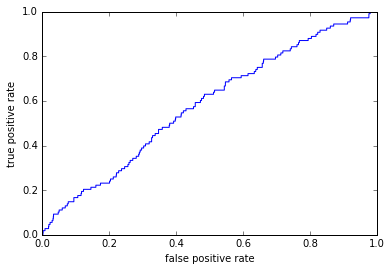

In [103]:
predictions = gbc.predict_proba(X_test)[:,1]
print "Accuracy:\t", accuracy_score(y_test, y_pred)

precisions, recalls, _ = precision_recall_curve(y_test, predictions, sample_weight=sw[test_idx])

print 'Precision:\t',precision_score(y_test, y_pred, sample_weight=sw[test_idx])

fpr, tpr, _ = roc_curve(y_test, predictions, sample_weight=sw[test_idx])
roc_auc = roc_auc_score(y_test, predictions, sample_weight=sw[test_idx])

print 'ROC_AUC:\t', roc_auc

plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

The accuracy is high which implies, given the data, the model is good at identifying the class 0 prospects.  Given the nature of the data, I'd like to have minimize the false positives as much as possible.  Therefore,
I'll consider <i> precision </i> as the metric to use to quantify the performance of the model. Having 65% precision is attributable to the data imbalance and the similarities between the converts and the non-converts
features.  It's about as good as can be expected so the model itself may need more conversion information for better precision.  This position is also reflected in the ROC curve is just better than 50/50.  Therefore, it would be best to identify which feature values are influencing the trend of the model which is presented below in the form of <i> partial dependency plots</i>.

In [105]:
ml_model = gbc
data_df_train = X_train

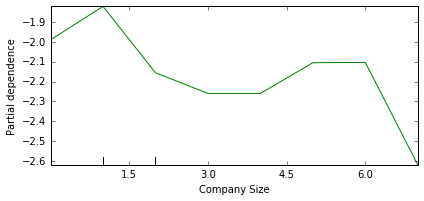

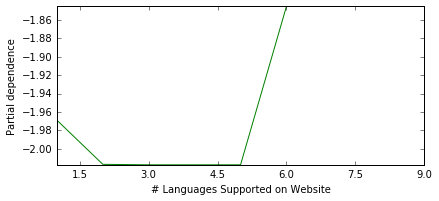

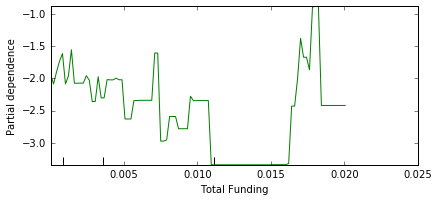

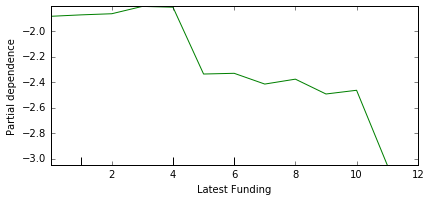

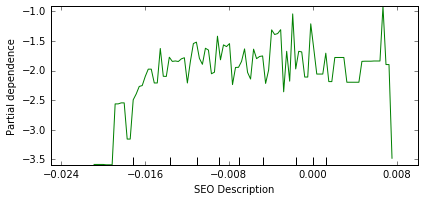

In [106]:
for elem in range(0,5):
    features_enum = [elem]
    fig, axs = plot_partial_dependence( ml_model, 
                                    data_df_train, 
                                    features_enum, 
                                    feature_names=data_df_train.columns,
                                    n_jobs=3, grid_resolution=100)
    plt.show()

## Actionable Responses: Native Features

<ul>
  <li>Focus on companies with 11-50 employees and 5001-10,000 employees.  In the first category, 
    it is likely that companies are getting more stable earlier on and want the leads to jump start their 
    product (or service).  For the larger company category, they may need more options since the low hanging fruit
    may have already been plucked.</li>
  <li>Websites which have been translated in 5 languages appear to convert more</li>
  <li>Focus on companies at Series B and Private Equity stages.  The reasons are almost identical to the 
    11-50 employees and 5001-10,000 employees cases </li>
  <li>SEO Description is not as interpretable</li>
</ul>

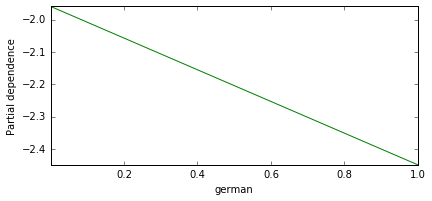

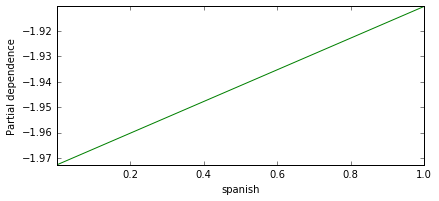

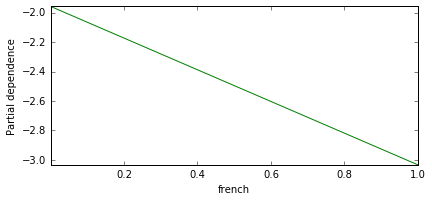

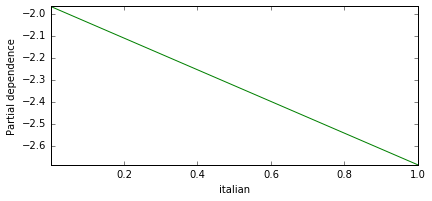

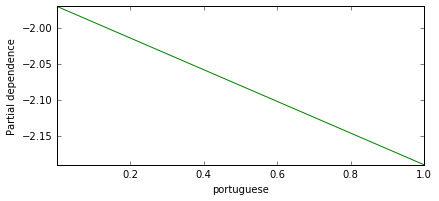

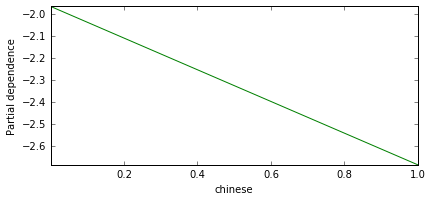

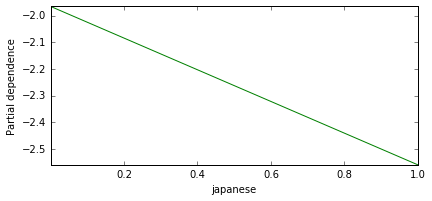

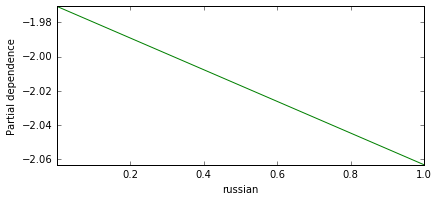

In [107]:
for elem in range(5,13):
    features_enum = [elem]
    fig, axs = plot_partial_dependence( ml_model, 
                                    data_df_train, 
                                    features_enum, 
                                    feature_names=data_df_train.columns,
                                    n_jobs=3, grid_resolution=100)
    plt.show()

## Actionable Responses: Websites in Various Languages

<ul>
  <li>Websites translated in different language do not express a trend in identifying which users will convert </li>
  <li>Focus on users that translated their website to European Spanish per the geographical entries in the state category</li>
</ul>

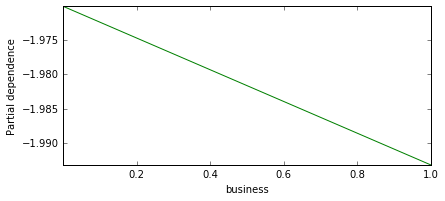

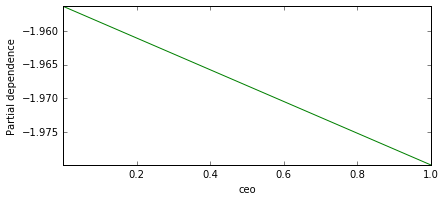

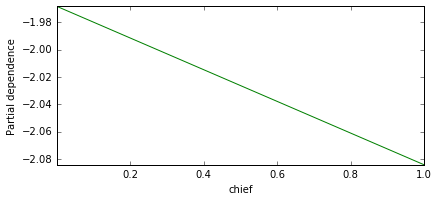

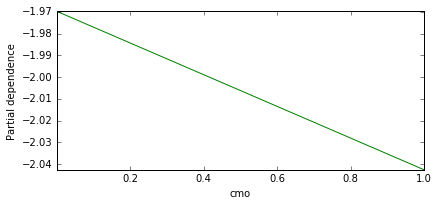

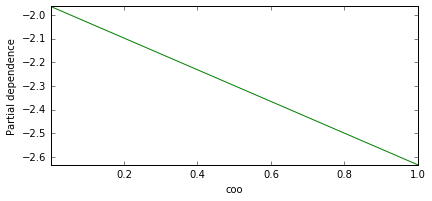

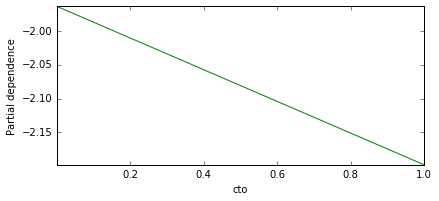

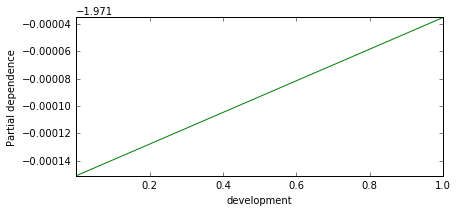

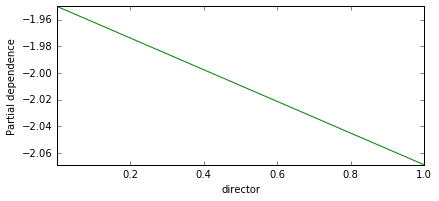

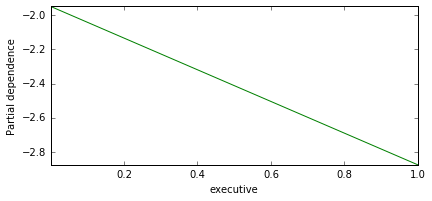

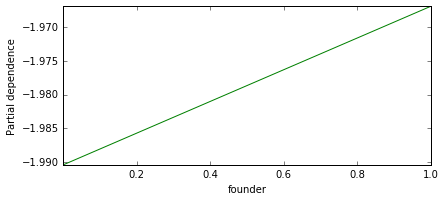

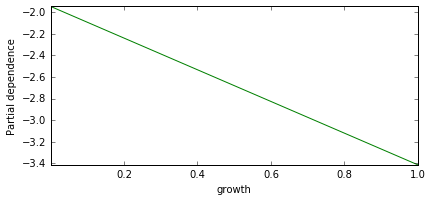

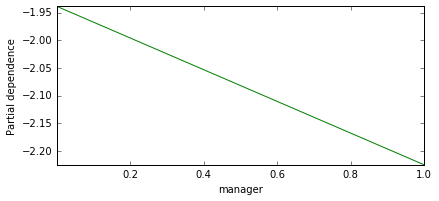

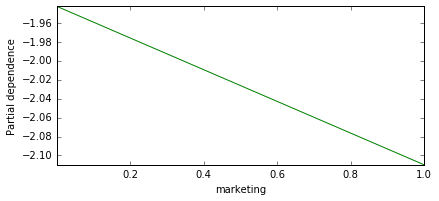

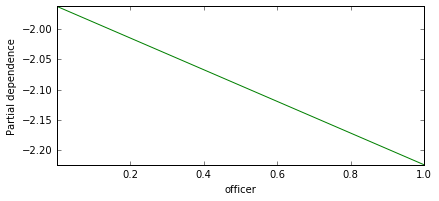

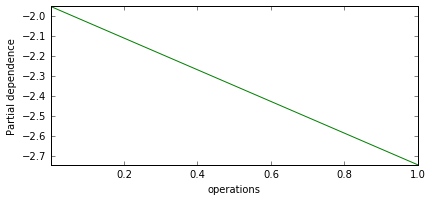

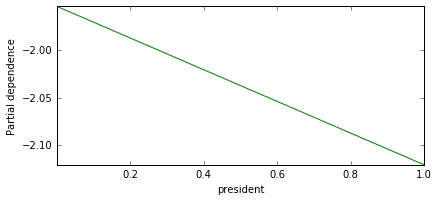

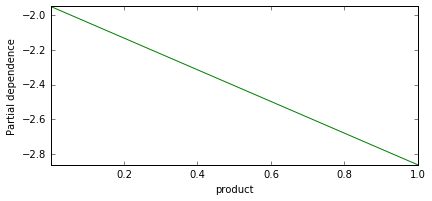

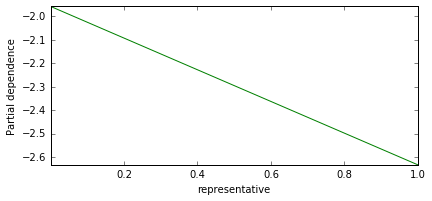

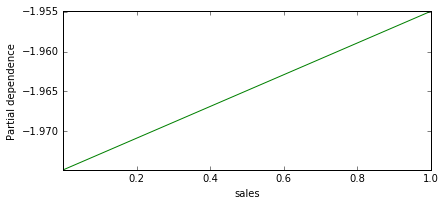

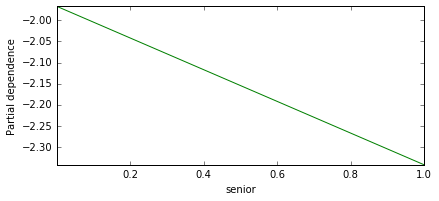

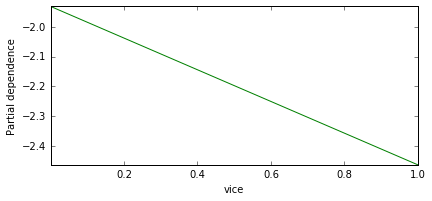

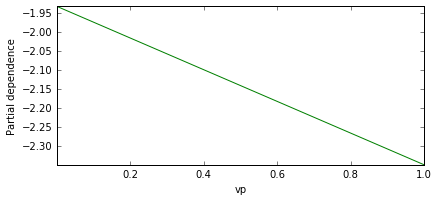

In [108]:
for elem in range(13,35):
    features_enum = [elem]
    fig, axs = plot_partial_dependence( ml_model, 
                                    data_df_train, 
                                    features_enum, 
                                    feature_names=data_df_train.columns,
                                    n_jobs=3, grid_resolution=100)
    plt.show()

## Actionable Responses: Job Titles

<ul>
  <li>Sales and Development Officers show an uptrend but the velocity is marginal. </li>
  <li>Focus on Founders as they have every incentive to build and sustain profitable relationships.</li>
</ul>

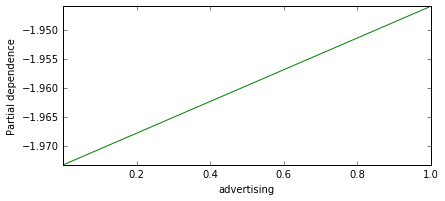

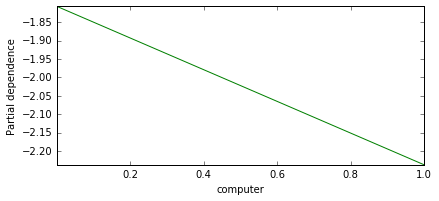

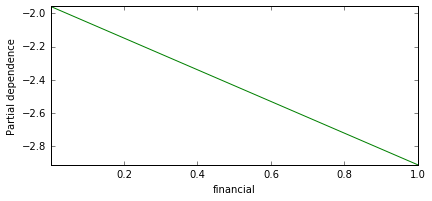

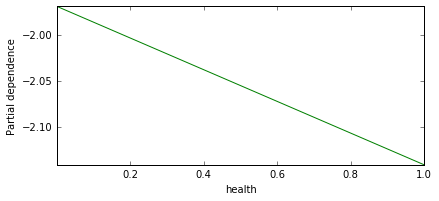

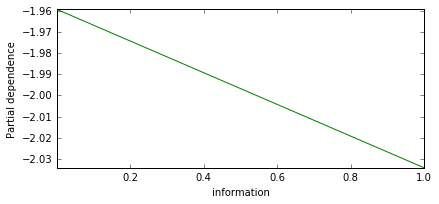

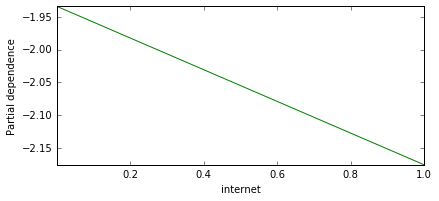

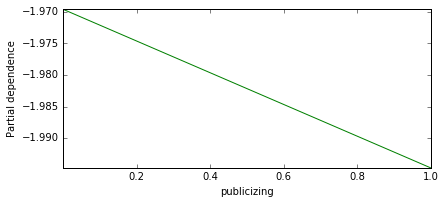

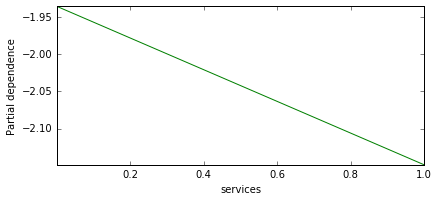

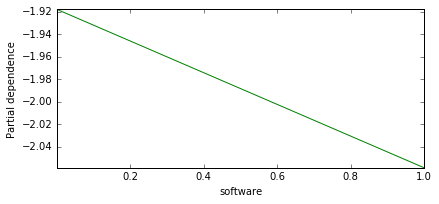

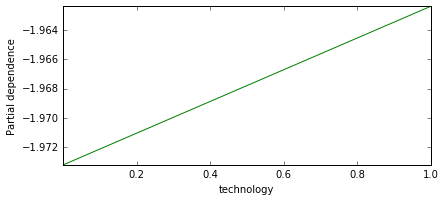

In [109]:
for elem in range(35,45):
    features_enum = [elem]
    fig, axs = plot_partial_dependence( ml_model, 
                                    data_df_train, 
                                    features_enum, 
                                    feature_names=data_df_train.columns,
                                    n_jobs=3, grid_resolution=100)
    plt.show()

## Actionable Responses: Industries

<ul>
  <li>Advertising and technology companies show the uptrend, focus on those for conversions. </li>
</ul>

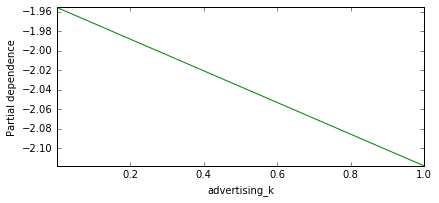

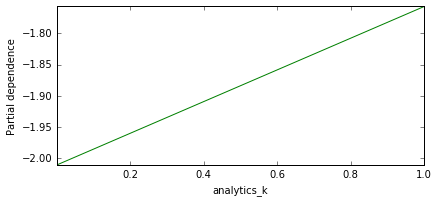

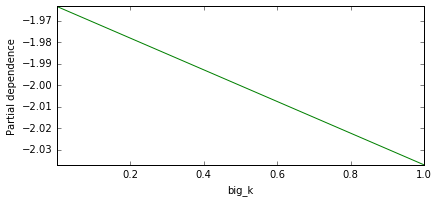

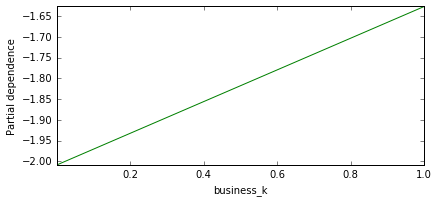

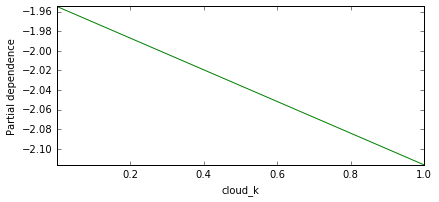

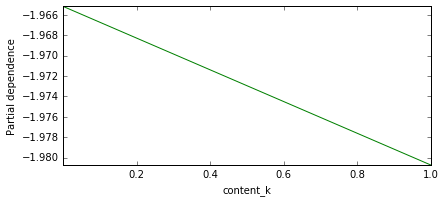

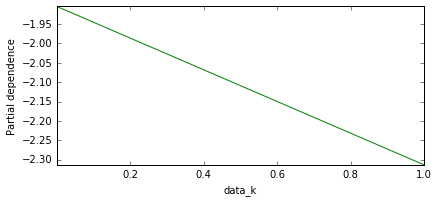

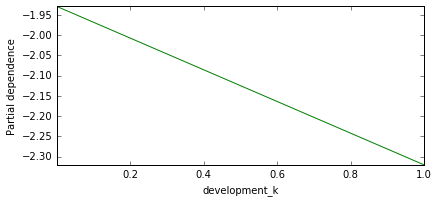

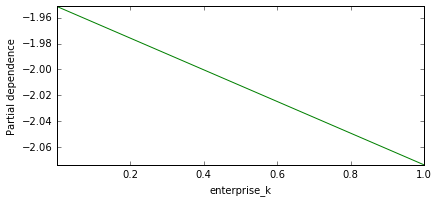

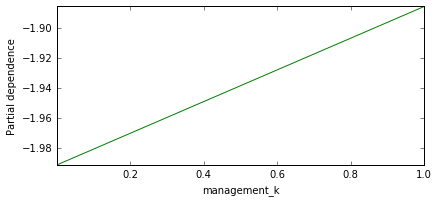

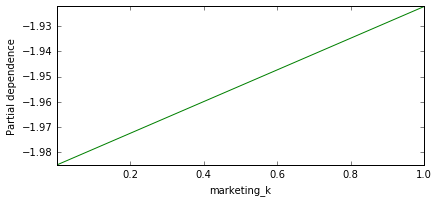

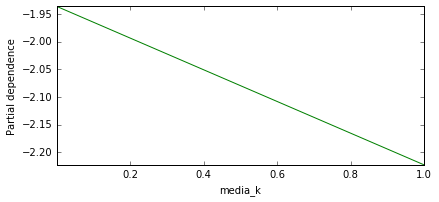

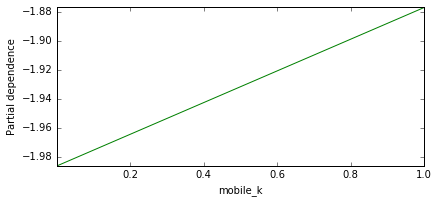

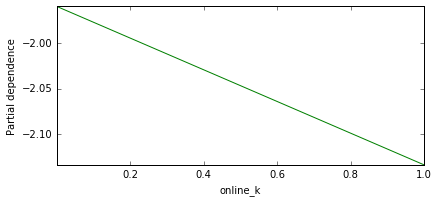

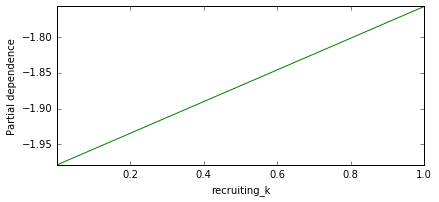

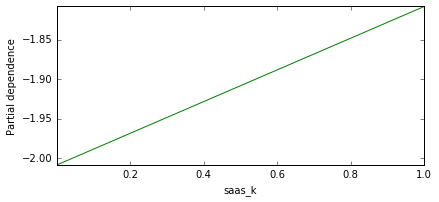

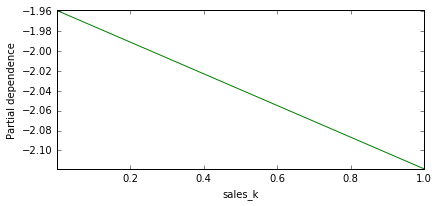

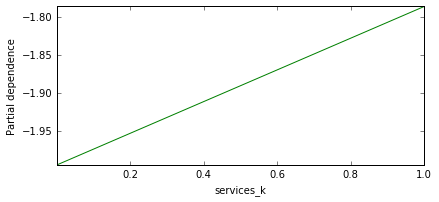

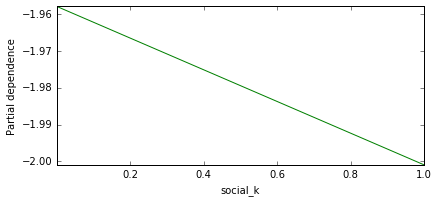

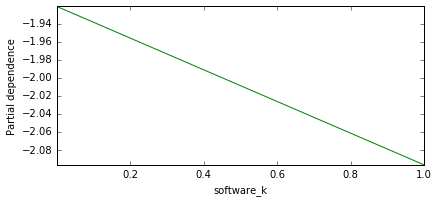

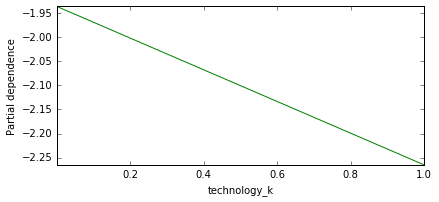

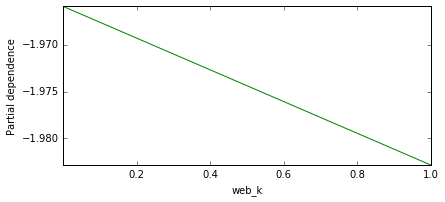

In [110]:
for elem in range(45,67):
    features_enum = [elem]
    fig, axs = plot_partial_dependence( ml_model, 
                                    data_df_train, 
                                    features_enum, 
                                    feature_names=data_df_train.columns,
                                    n_jobs=3, grid_resolution=100)
    plt.show()

## Actionable Responses: Keywords

Companies that describe their service with the following keyword attributes may have tendencies to convert.
<ul>
  <li> Recruiting </li>
  <li> Analytics </li>
  <li> Mobile </li>
  <li> SaaS </li>
</ul>

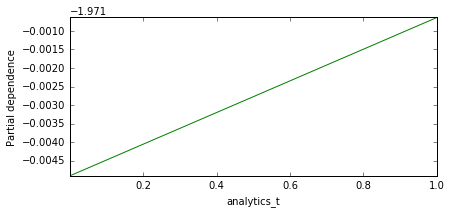

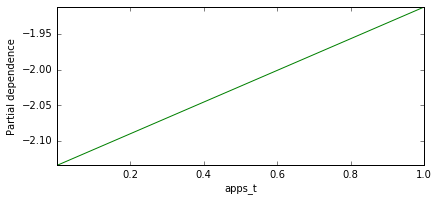

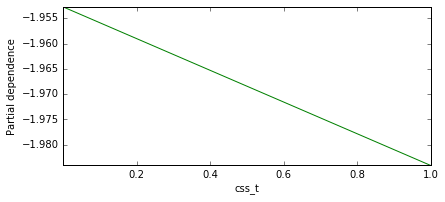

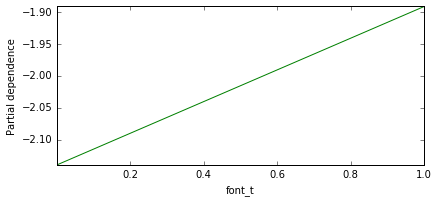

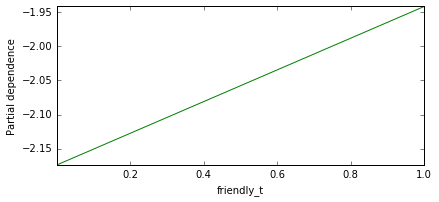

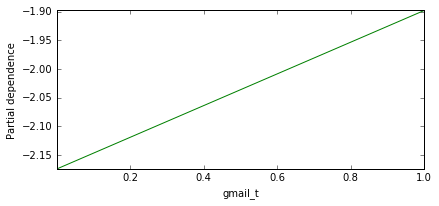

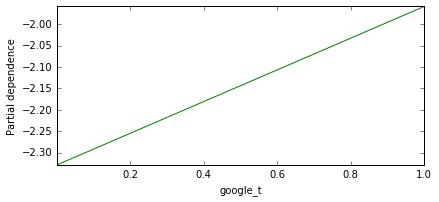

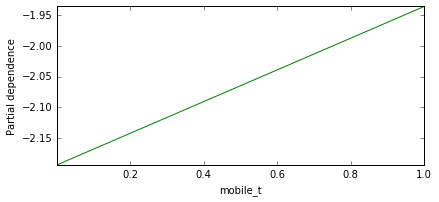

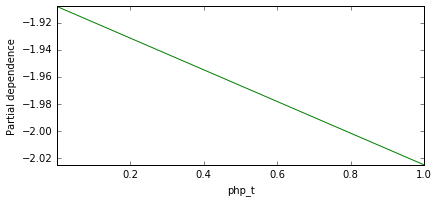

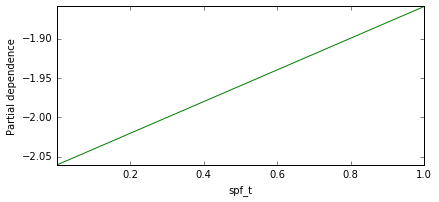

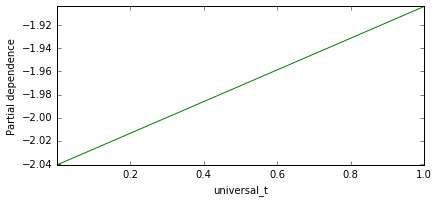

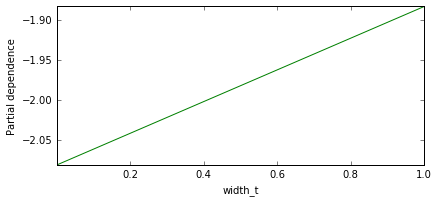

In [111]:
for elem in range(67,79):
    features_enum = [elem]
    fig, axs = plot_partial_dependence( ml_model, 
                                    data_df_train, 
                                    features_enum, 
                                    feature_names=data_df_train.columns,
                                    n_jobs=3, grid_resolution=100)
    plt.show()

## Actionable Responses: Technologies

Companies that describe their service with the following technology attributes may have tendencies to convert.
<ul>
  <li> Analytics </li>
  <li> Apps </li>
  <li> Mobile-Friendly </li>
</ul>

Results are very similar to the <b> Keyword </b> feature analysis.

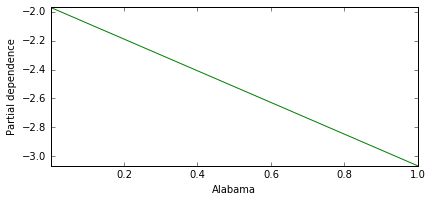

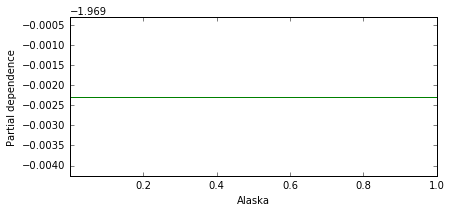

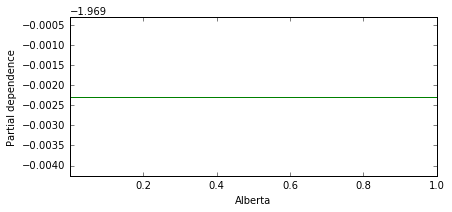

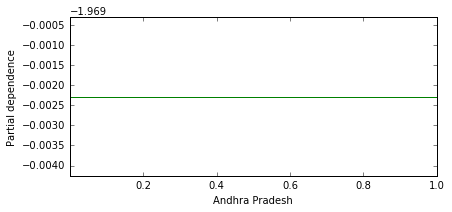

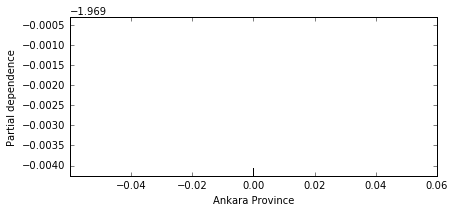

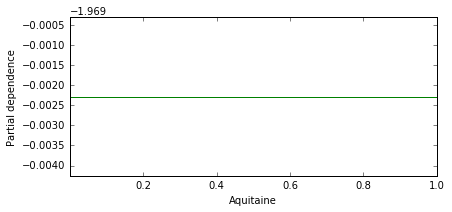

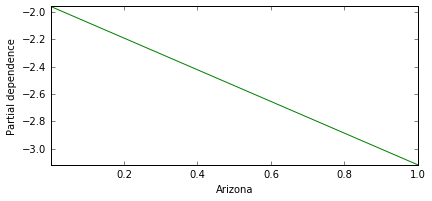

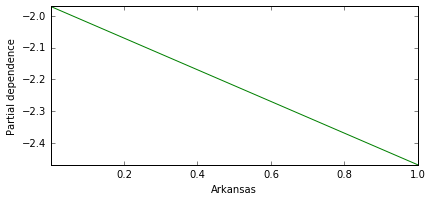

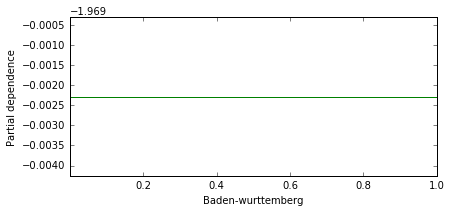

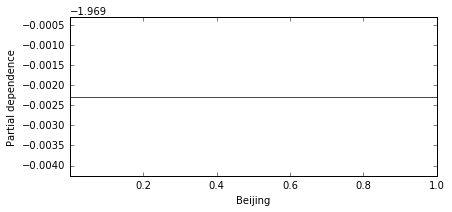

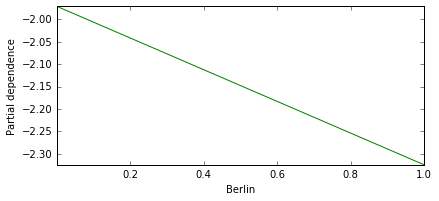

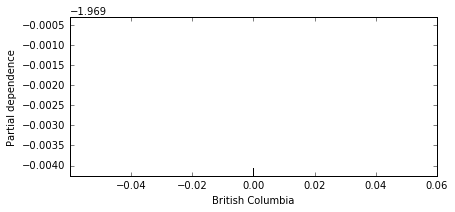

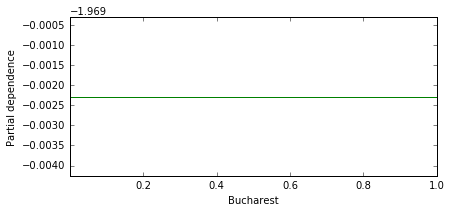

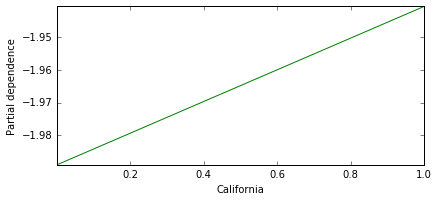

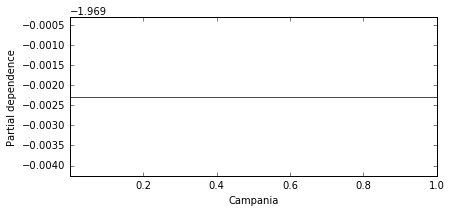

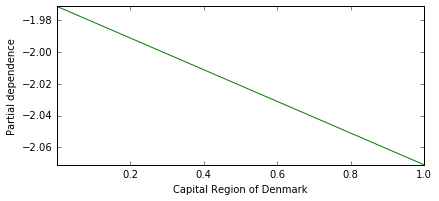

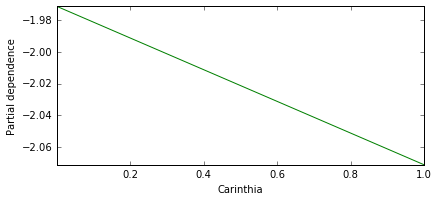

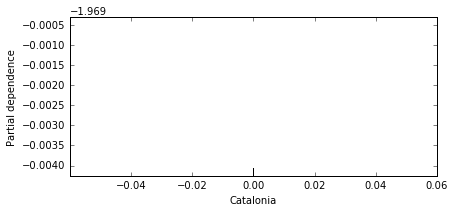

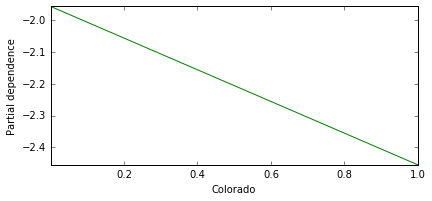

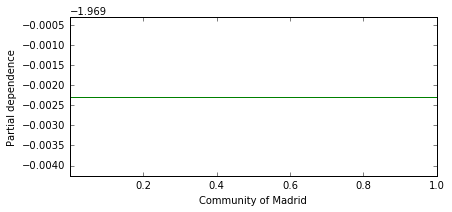

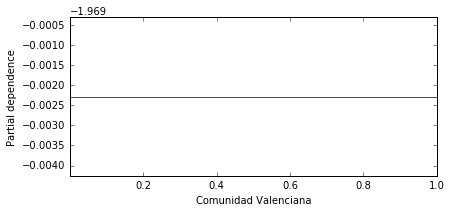

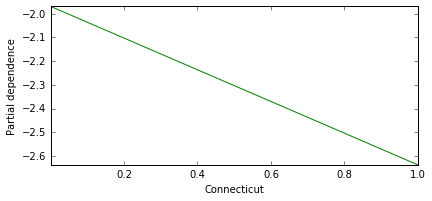

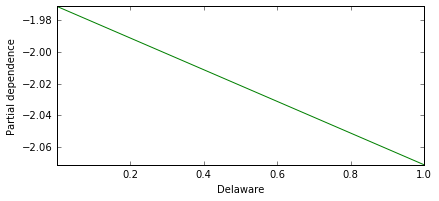

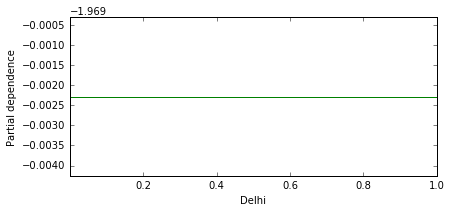

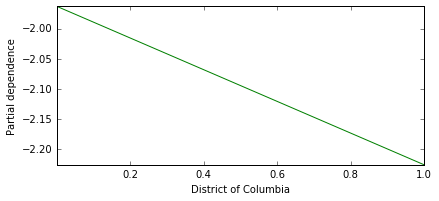

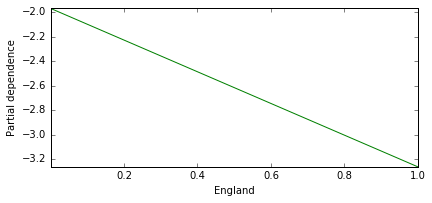

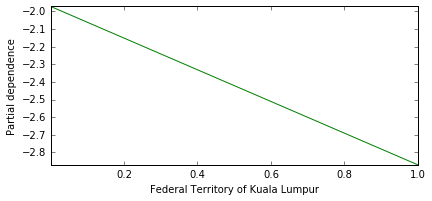

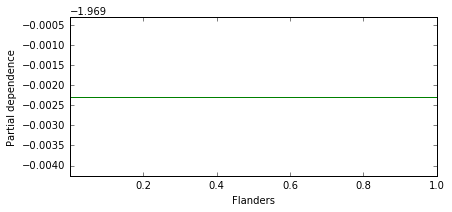

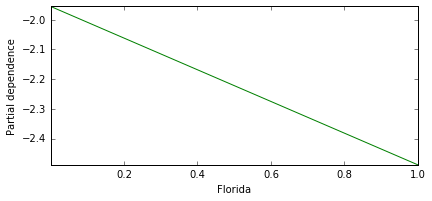

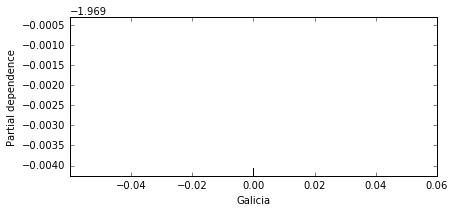

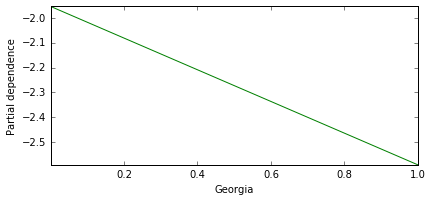

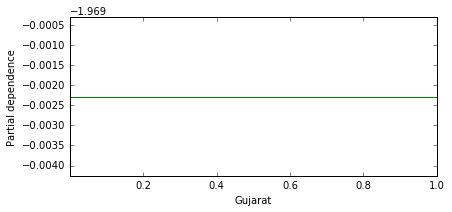

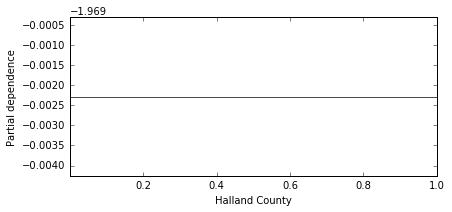

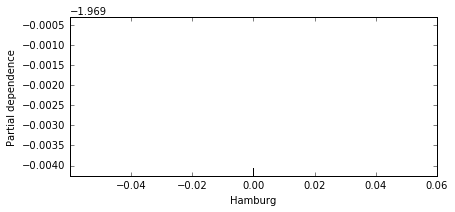

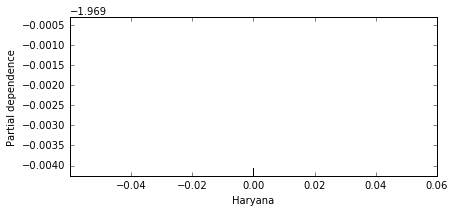

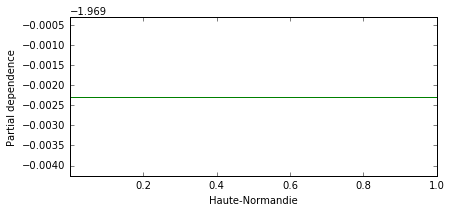

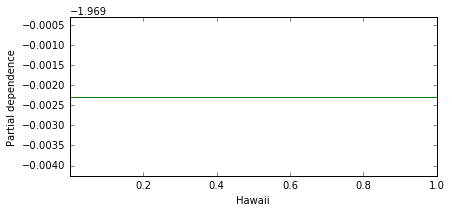

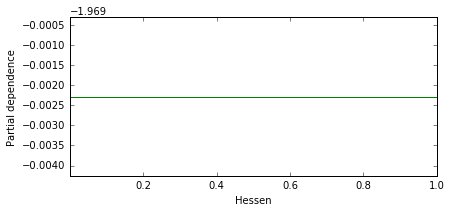

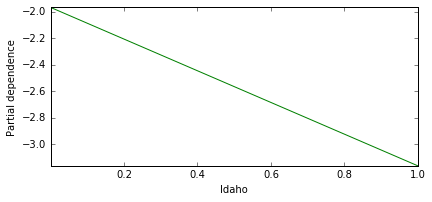

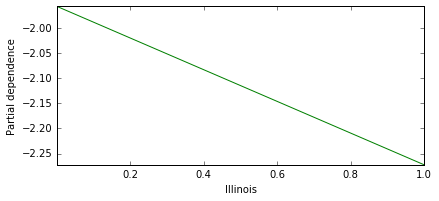

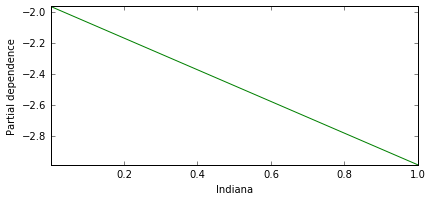

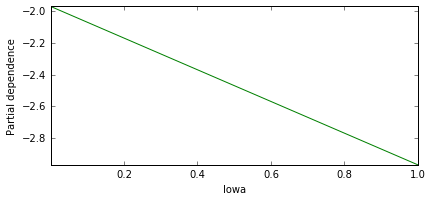

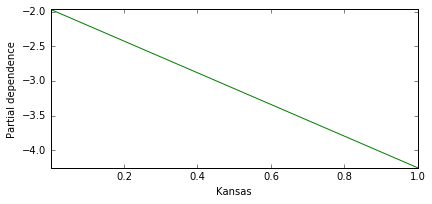

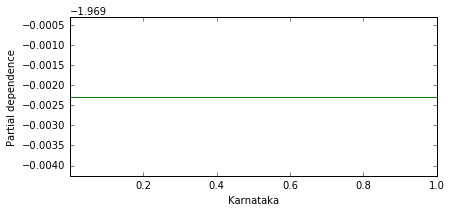

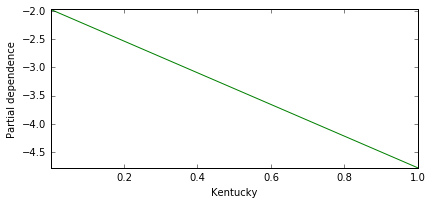

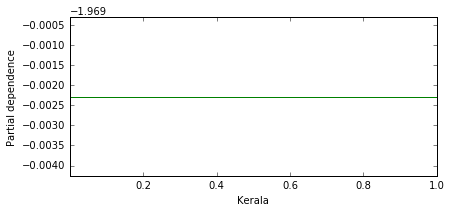

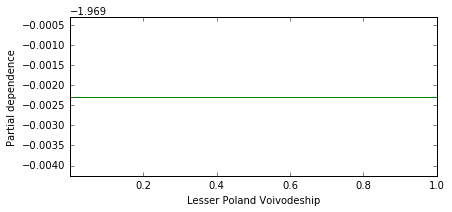

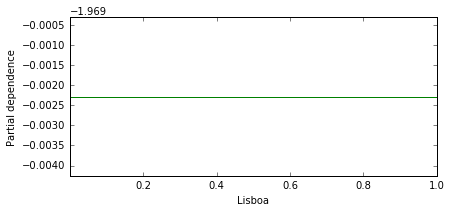

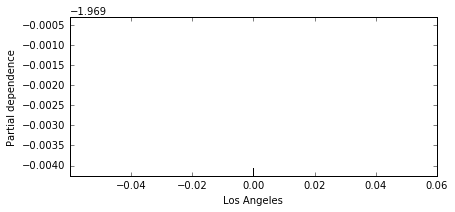

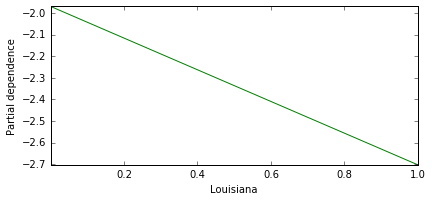

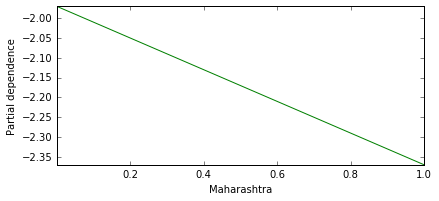

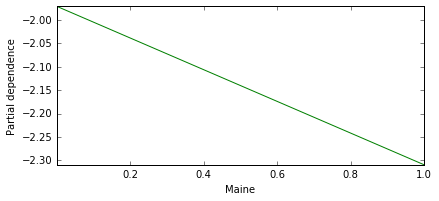

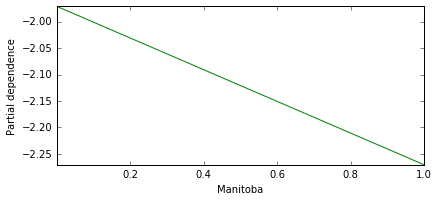

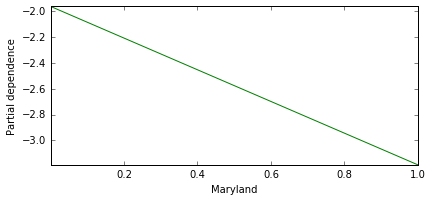

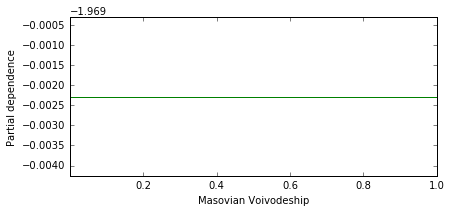

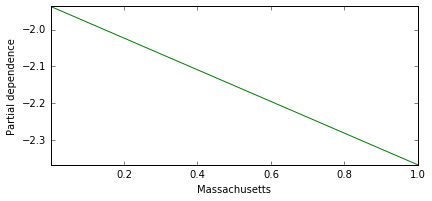

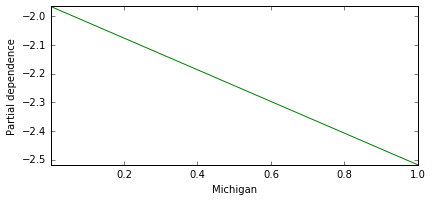

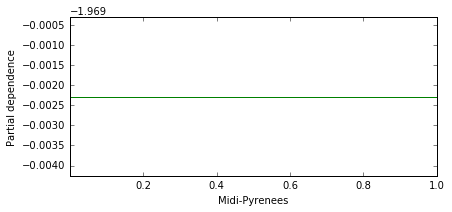

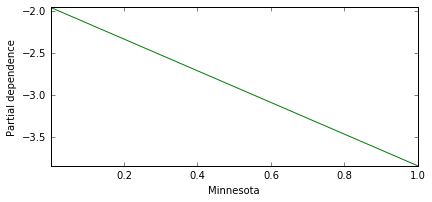

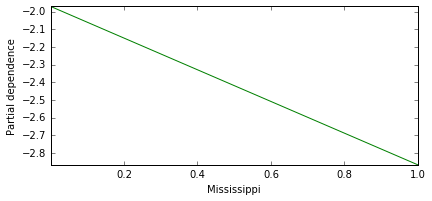

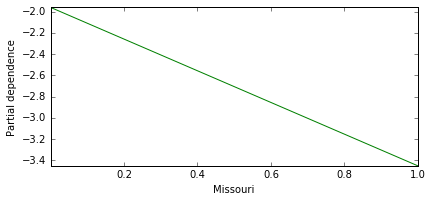

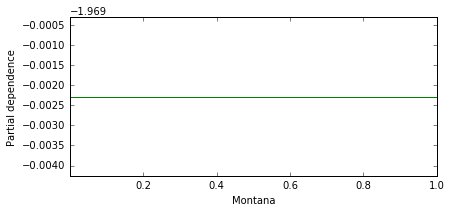

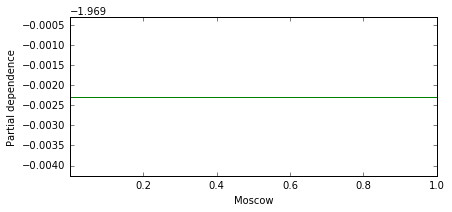

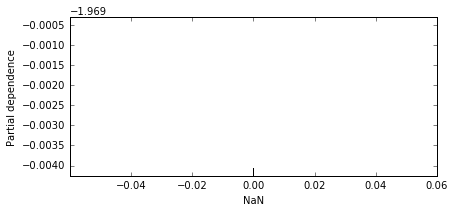

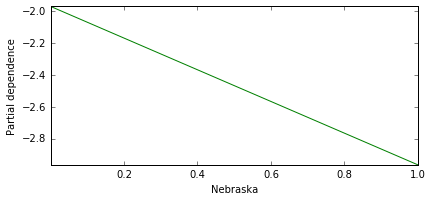

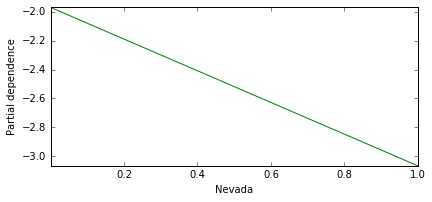

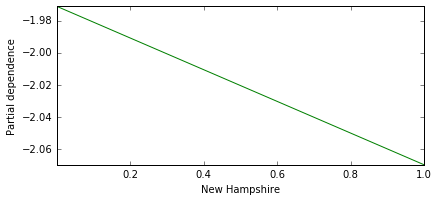

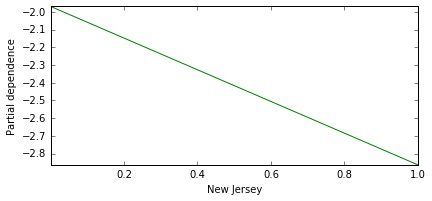

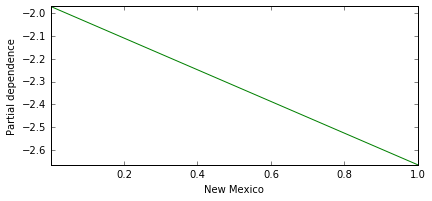

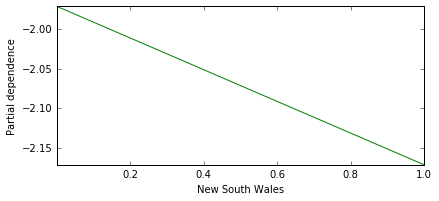

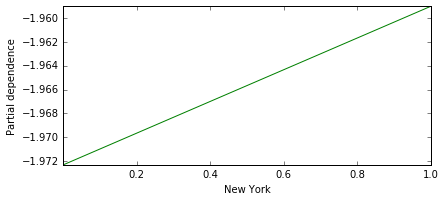

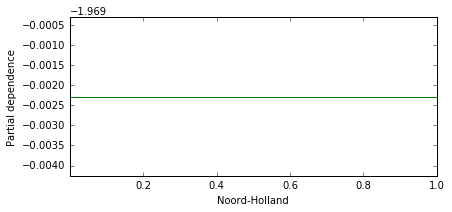

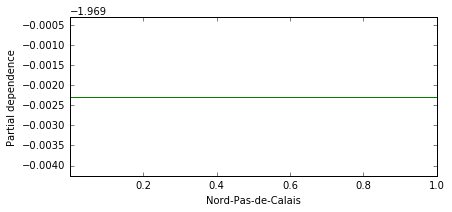

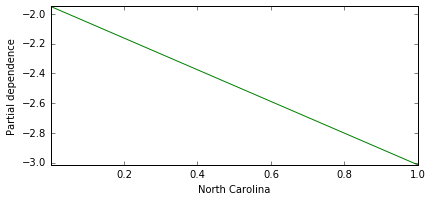

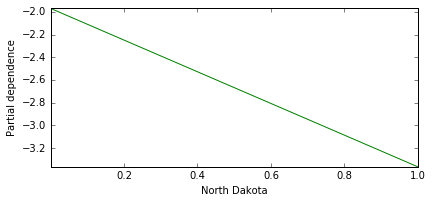

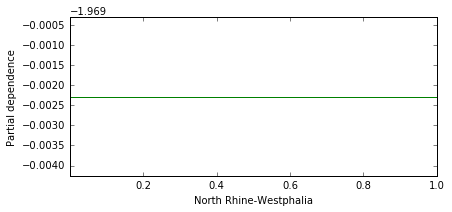

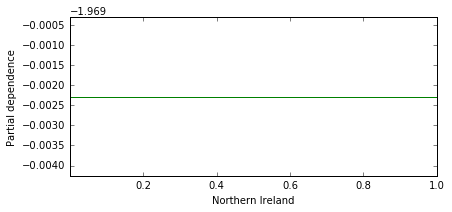

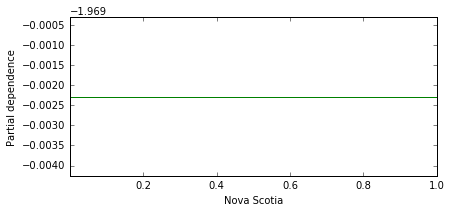

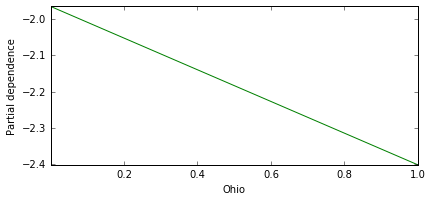

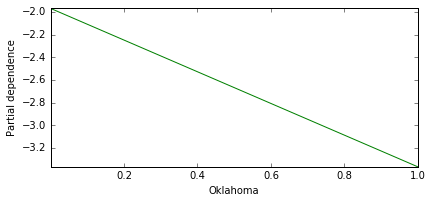

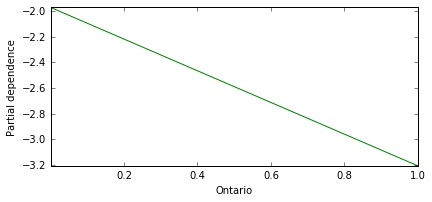

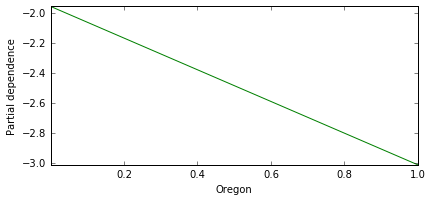

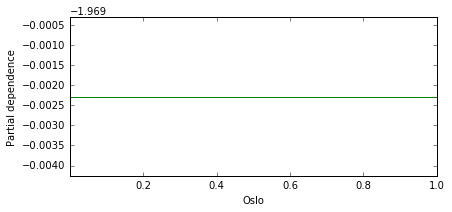

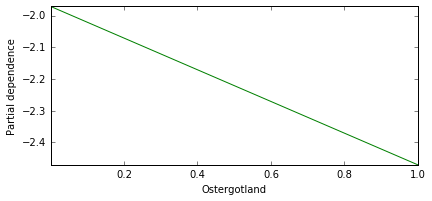

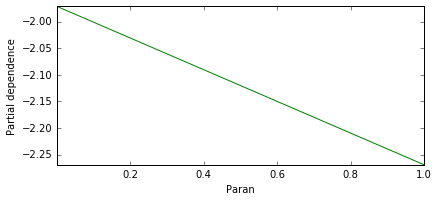

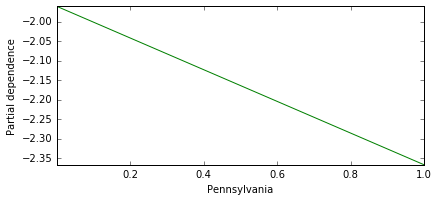

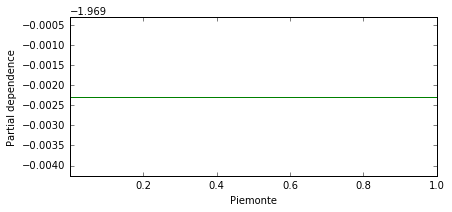

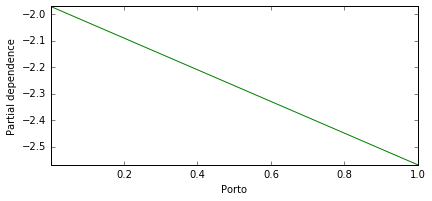

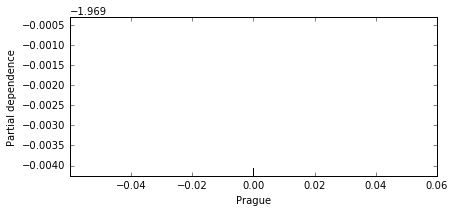

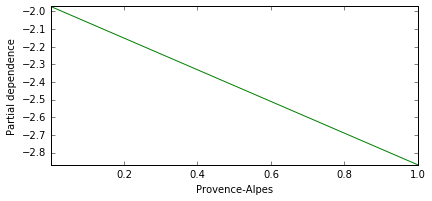

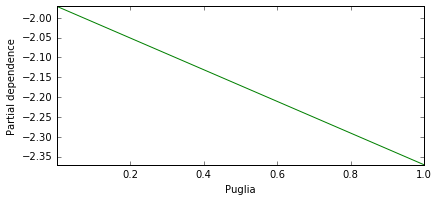

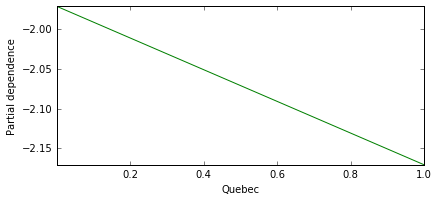

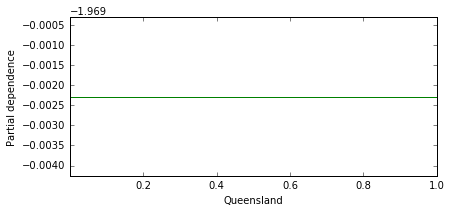

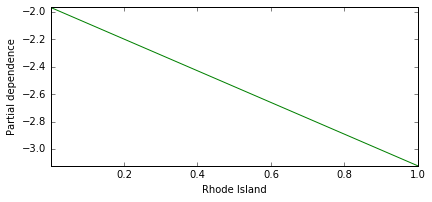

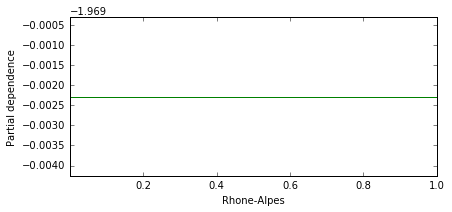

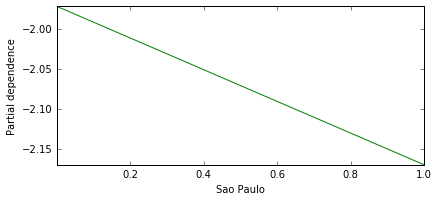

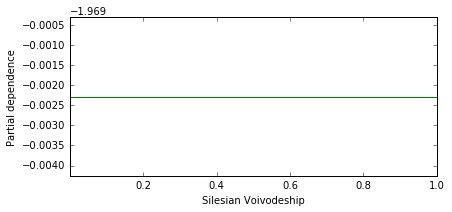

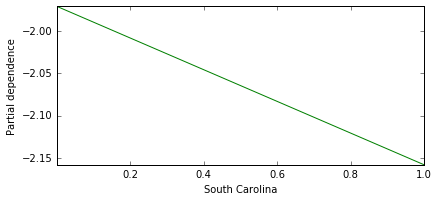

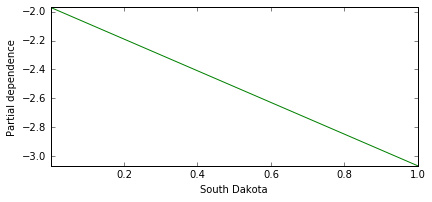

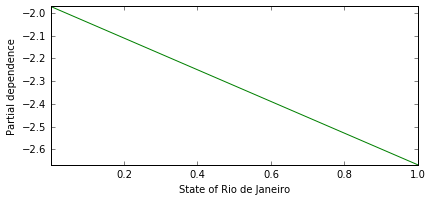

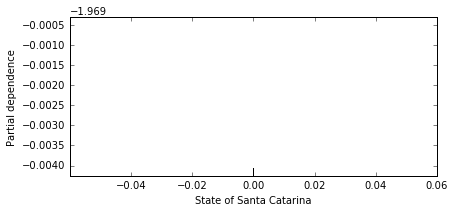

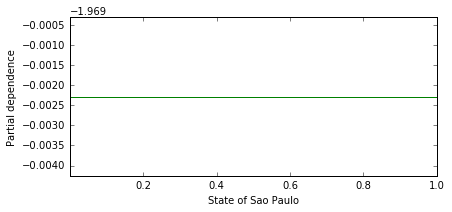

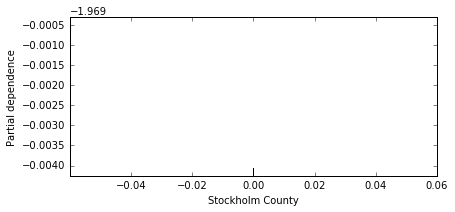

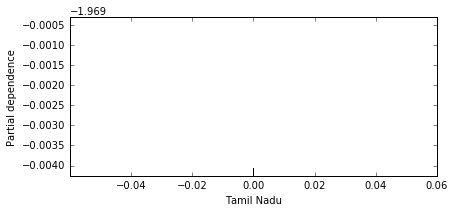

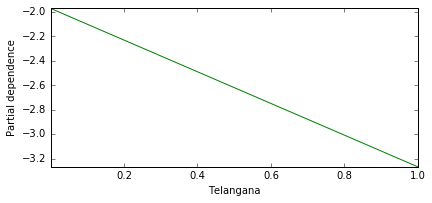

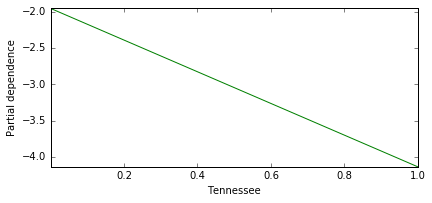

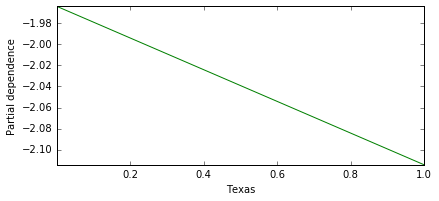

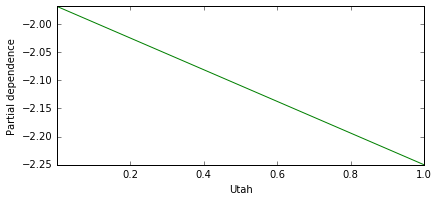

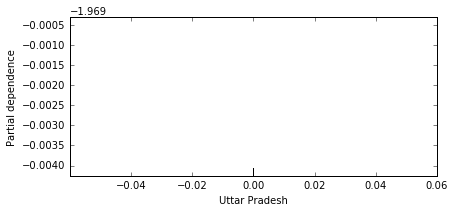

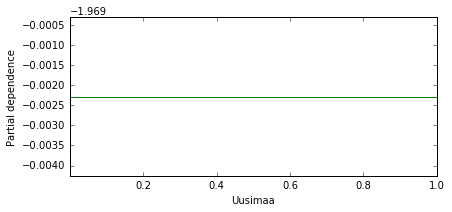

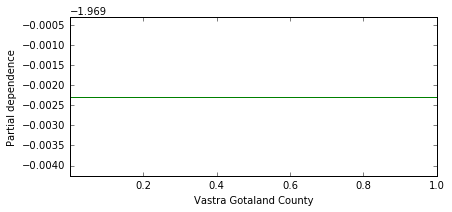

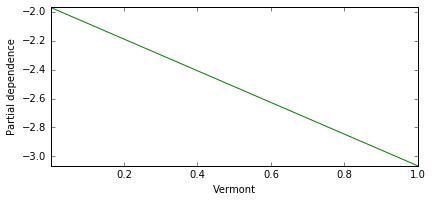

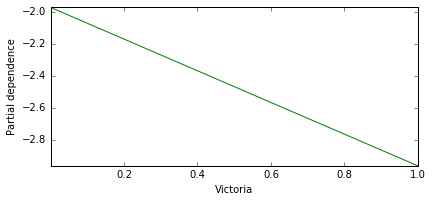

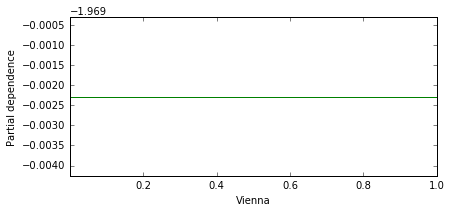

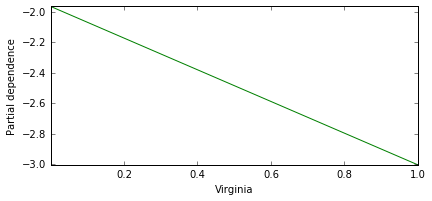

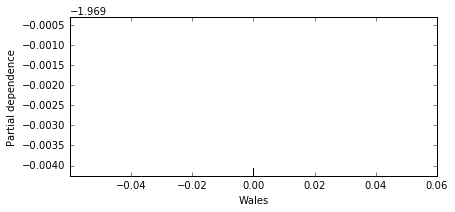

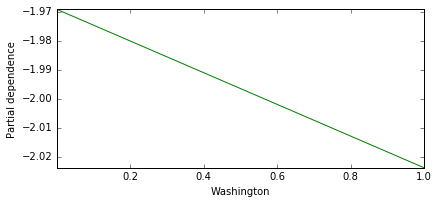

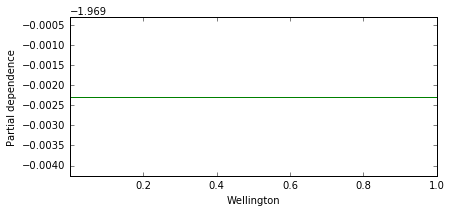

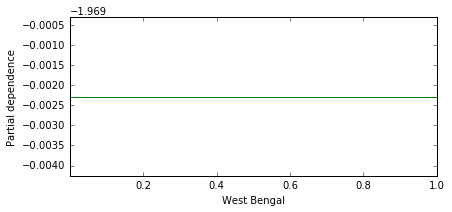

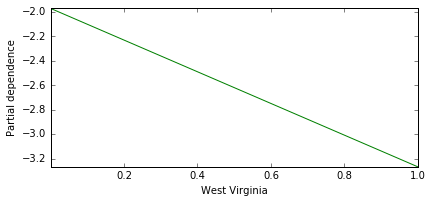

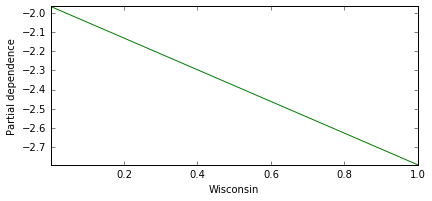

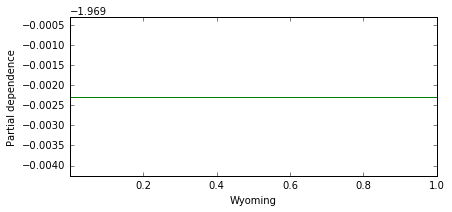

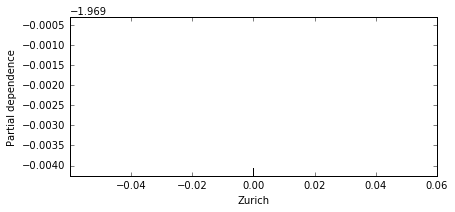

In [112]:
for elem in range(79,202):
    features_enum = [elem]
    fig, axs = plot_partial_dependence( ml_model, 
                                    data_df_train, 
                                    features_enum, 
                                    feature_names=data_df_train.columns,
                                    n_jobs=3, grid_resolution=100)
    plt.show()

## Actionable Responses: Location

<ul>
  <li> Countries outside of the US have little to no trend.  Might be an opportunity since their entries in the data are sparse at best. </li>
  <li> Midwest based companies have the least trend to convert; might also be another opportunity expand their reach with the right marketing.</li>
  <li> California based companies have the strongest trend to convert </li>
</ul>